# CS4487 Group Project

**Team members:**
 - Ilias Batyrbekov (55591554)
 - Lazar Galić (56158707)

## Contents

 1. Introduction
 2. Classical convolutional neural networks
 3. Error level analysis enhancements
 4. EfficientNet
 5. Xception

## Introduction

Provided with a 12000-image dataset, our goal is to create a binary classifier capable of recognizing whether a given image is real or fake.

We have used the following terms to refer to some important concepts throughout the paper:
 - _central face features_ - features that define the facial expression (eyes, mouth, nose, eyebrows).
 - _initial person/image_ - the person/image that was used as a base for the deepfake, for which the features were altered.
 - _donor person/image_ - the person/image from which the newly added/replaced features were taken.

There are 3 classes of images, 4000 images each:
 - **_real_** - images that were originally taken with a camera, not altered in any way.
 - **_fake_face2face_** - images for which the topological shapes of central face features were altered, but their look (colors) was preserved, as if the initial person changed the facial expression but remained the same.
 - **_fake_deepfake_** - images for which the entirety of the central face features (with colors) was transferred, as if the entirety of the initial person's face was swapped with the donor's face.


`real`, `fake_face2face`, `fake_deepfake` images

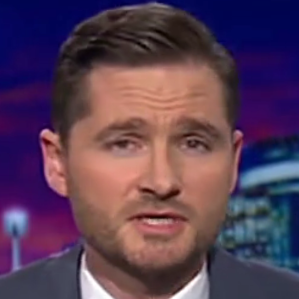
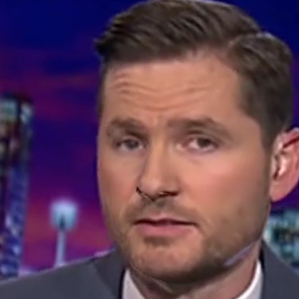
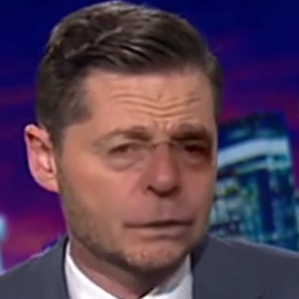



Some information that can be immediately noticed about the dataset:
 - There are 4000 images for each of the labels.
 - Images have size 299x299x3, and are all in `.png` format.
 - Images of the same person in different face positions are in groups of 5 - e.g. `fake_deepfake/1234.png` and `fake_face2face/1234.png` were generated from `real/1234.png`.
 - Same index for each label corresponds to the initial real face and two generated deepfakes - e.g. `1231.png`,`1232.png`,`1233.png`,`1234.png` and `1235.png` all represent the same face.
 - Most faces have the nose roughly in the center of the photo, but there is a lot of images taken from the side, so the head may not be centered.

### Imports

In [ ]:
import numpy as np                  # NumPy
import cv2                          # OpenCV for image processing
import gc                           # Garbage collection
import glob                         # Path browsing
import matplotlib.pyplot as plt     # PyPlot
import random                       # Pseudorandom generators
import tensorflow as tf             # TensorFlow
import time                         # Time management (for timestamps)
import threading                    # Multithreading (for image loading)
from PIL import Image, ImageChops, ImageEnhance # Pillow library
import sys, os                      # Primitive system tools
import pandas as pd                 # Pandas
import seaborn as sn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data manager

We created our own `DataManager` class to load and store the images efficiently, and easily apply different transformations on the data.

The data manager supports 2 modes - binary and non-binary classification. Namely, we noticed that some models perform better if we train them to recognize `fake_deepfake` and `fake_face2face` as separate classes, and label them appropriately. This can eas

In [ ]:
class DataManager:
    
    rootPath = "."
    imageDim = 299
    binary = False

    elaQuality = 90
    tmpExt = ".tmp_ela.jpg"
    elaExt = ".ela.png"
    elaWeight = 0.4

    paths = ([], [], [])
    labels = ("real", "fake_deepfake", "fake_face2face")
    zone = None

    trainSet = None
    validSet = None
    testSet = None

    trainLabels = None
    validLabels = None
    testLabels = None

    trainSize = 0
    validSize = 0
    testSize = 0

    def __init__(self,rootPath,imageDim,binary,elaWeight=0.4):
        self.rootPath = rootPath
        self.imageDim = imageDim
        self.binary = binary
        self.elaWeight = elaWeight

    def loadPaths(self):
        self.paths = ([], [], [])
        pathPattern = self.rootPath + "{}/*.png"
        for idx, label in enumerate(self.labels):
            self.paths[idx].extend(glob.glob(pathPattern.format(label)))


    def printStatus(self):
        print("Total path count")
        for idx, label in enumerate(self.labels):
            print("  {:<14} : {}".format(label,len(self.paths[idx])))
        
        if (self.zone):
            print("Zone: {} - {} (NOTE: Zone takes this range for each label!)".format(self.zone[0],self.zone[1]))


    def getPaths(self,zone,shuffle=True,randomSeed=None,testSet=False):
        labelledPaths = []

        for idx in range(len(self.labels)):
            for i in range(zone[0],zone[1]):
                labelledPaths.append((idx,self.paths[idx][i]))

        if (shuffle):
            if (isinstance(randomSeed,int)):
                random.seed(randomSeed)
            random.shuffle(labelledPaths)
        
        gc.collect()
        return labelledPaths


    def loadImages(self,zone,shuffle=True,randomSeed=None,testSet=False):

        labelledPaths = self.getPaths(zone,shuffle=shuffle,randomSeed=randomSeed,testSet=testSet)

        idx = 0
        index = 0

        totalCount = len(labelledPaths)

        validCount = totalCount // 6
        testCount = 0

        if (testSet):
            testCount = totalCount // 6

        trainCount = totalCount - validCount - testCount

        self.trainSet = None
        self.validSet = None
        self.testSet = None

        gc.collect()
        
        self.trainSet = np.empty((trainCount,self.imageDim,self.imageDim,3))
        self.validSet = np.empty((validCount,self.imageDim,self.imageDim,3))
        self.testSet = np.empty((testCount,self.imageDim,self.imageDim,3))

        self.trainLabels = np.empty((trainCount,)).astype('byte')
        self.validLabels = np.empty((validCount,)).astype('byte')
        self.testLabels = np.empty((testCount,)).astype('byte')
        
        self.trainSize = trainCount
        self.validSize = validCount
        self.testSize = testCount

        gc.collect()

        threads = []

        for label, path in labelledPaths:
            # thread = threading.Thread(target=self.processFile, args=[label,path,idx,trainCount,validCount,testCount])
            # threads.append(thread)
            # thread.start()
            self.processFile(label,path,idx,trainCount,validCount,testCount)
            idx += 1

        for thread in threads:
            thread.join()
        
        gc.collect()

    def processFile(self,label,path,idx,trainCount,validCount,testCount):
        index = idx

        if (self.binary) and (label > 0):
            label = 1

        if (idx >= trainCount + validCount):
            index -= trainCount + validCount
            self.testSet[index] = self.loadImage(path)
            self.testLabels[index] = label
        elif (idx >= trainCount):
            index -= trainCount
            self.validSet[index] = self.loadImage(path)
            self.validLabels[index] = label
        else:
            self.trainSet[index] = self.loadImage(path)
            self.trainLabels[index] = label

        print("Imported {}.".format(idx+1))

        gc.collect()

    def loadImage(self,path):
        image = cv2.imread(path).astype('float32')
        image = cv2.resize(image,dsize=(self.imageDim,self.imageDim),interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) / 255
        image = cv2.GaussianBlur(image, (3,3), 0) * (1 - self.elaWeight) + self.calculateEla(np.uint8(image * 255),path) * self.elaWeight;
        gc.collect()
        return image
    
    def calculateEla(self,image,path):
        tmpPath = path + self.tmpExt

        imFile = Image.fromarray(image)
        imFile.save(tmpPath, 'JPEG', quality=self.elaQuality)

        compressedFile = Image.open(tmpPath)
        imFile = ImageChops.difference(imFile, compressedFile)

        gc.collect()

        extrema = imFile.getextrema()
        maxDiff = max([ex[1] for ex in extrema])
        scale = 255.0/maxDiff
        imFile = ImageEnhance.Brightness(imFile).enhance(scale)

        image = np.array(imFile) / 255.0

        gc.collect()

        return image
    
    def getGeneralInfo(self,zone,shuffle=True,randomSeed=None,testSet=False):
        data = { 'train': [0, 0, 0], 'valid': [0, 0, 0], 'test': [0, 0, 0] }

        labelledPaths = self.getPaths(zone,shuffle=shuffle,randomSeed=randomSeed,testSet=testSet)

        idx = 0
        totalCount = len(labelledPaths)

        validCount = totalCount // 6
        testCount = 0

        if (testSet):
            testCount = totalCount // 6

        trainCount = totalCount - validCount - testCount

        for label, path in labelledPaths:
            index = idx
            if (idx >= trainCount + validCount):
                index -= trainCount + validCount
                data['test'][label] += 1
            elif (idx >= trainCount):
                index -= trainCount
                data['valid'][label] += 1
            else:
                data['train'][label] += 1

            idx += 1
            
        return data

    
    # def getTrainSet(self):
    #     return self.trainSet
    # def getValidSet(self):
    #     return self.validSet
    # def getTestSet(self):
    #     return self.testSet

    # def getTrainLabels(self):
    #     return self.trainLabels
    # def getValidLabels(self):
    #     return self.validLabels
    # def getTestLabels(self):
    #     return self.testLabels

    # def getTrainSize(self):
    #     return self.trainSize
    # def getValidSize(self):
    #     return self.validSize
    # def getTestSize(self):
    #     return self.testSize

    def getTrainLabelsCat(self):
        return tf.keras.utils.to_categorical(self.trainLabels)
    def getValidLabelsCat(self):
        return tf.keras.utils.to_categorical(self.validLabels)
    def getTestLabelsCat(self):
        return tf.keras.utils.to_categorical(self.testLabels)

    def showImage(self,image,label):
        plt.title("'{}' image".format(self.labels[label]))
        plt.imshow(image)
        plt.show()
    
    def showTrainImage(self,index):
        self.showImage(self.trainSet[index],self.trainLabels[index])
    
    def showValidImage(self,index):
        self.showImage(self.validSet[index],self.validLabels[index])
    
    def showTestImage(self,index):
        self.showImage(self.testSet[index],self.testLabels[index])     

    def getInputShape(self):
        return (self.imageDim,self.imageDim,3)   

In [ ]:
dmmini = DataManager("/content/drive/MyDrive/CS4487GP/dataset/",74,False,elaWeight=0)
dmmini.loadPaths()
dmmini.printStatus()
dmmini.loadImages((0,2000),randomSeed=0)

Streaming output truncated to the last 5000 lines.
Imported 1001.
Imported 1002.
Imported 1003.
Imported 1004.
Imported 1005.
Imported 1006.
Imported 1007.
Imported 1008.
Imported 1009.
Imported 1010.
Imported 1011.
Imported 1012.
Imported 1013.
Imported 1014.
Imported 1015.
Imported 1016.
Imported 1017.
Imported 1018.
Imported 1019.
Imported 1020.
Imported 1021.
Imported 1022.
Imported 1023.
Imported 1024.
Imported 1025.
Imported 1026.
Imported 1027.
Imported 1028.
Imported 1029.
Imported 1030.
Imported 1031.
Imported 1032.
Imported 1033.
Imported 1034.
Imported 1035.
Imported 1036.
Imported 1037.
Imported 1038.
Imported 1039.
Imported 1040.
Imported 1041.
Imported 1042.
Imported 1043.
Imported 1044.
Imported 1045.
Imported 1046.
Imported 1047.
Imported 1048.
Imported 1049.
Imported 1050.
Imported 1051.
Imported 1052.
Imported 1053.
Imported 1054.
Imported 1055.
Imported 1056.
Imported 1057.
Imported 1058.
Imported 1059.
Imported 1060.
Imported 1061.
Imported 1062.
Imported 1063.
Impo

In [ ]:
dm = DataManager("/content/drive/MyDrive/CS4487GP/dataset/",299,False)
dm.loadPaths()
dm.printStatus()
dm.loadImages((0,4000),randomSeed=0,testSet=True)

Streaming output truncated to the last 5000 lines.
Imported 7001.
Imported 7002.
Imported 7003.
Imported 7004.
Imported 7005.
Imported 7006.
Imported 7007.
Imported 7008.
Imported 7009.
Imported 7010.
Imported 7011.
Imported 7012.
Imported 7013.
Imported 7014.
Imported 7015.
Imported 7016.
Imported 7017.
Imported 7018.
Imported 7019.
Imported 7020.
Imported 7021.
Imported 7022.
Imported 7023.
Imported 7024.
Imported 7025.
Imported 7026.
Imported 7027.
Imported 7028.
Imported 7029.
Imported 7030.
Imported 7031.
Imported 7032.
Imported 7033.
Imported 7034.
Imported 7035.
Imported 7036.
Imported 7037.
Imported 7038.
Imported 7039.
Imported 7040.
Imported 7041.
Imported 7042.
Imported 7043.
Imported 7044.
Imported 7045.
Imported 7046.
Imported 7047.
Imported 7048.
Imported 7049.
Imported 7050.
Imported 7051.
Imported 7052.
Imported 7053.
Imported 7054.
Imported 7055.
Imported 7056.
Imported 7057.
Imported 7058.
Imported 7059.
Imported 7060.
Imported 7061.
Imported 7062.
Imported 7063.
Impo

In [ ]:
def plotHistory(history):
    epochRange = range(1,len(history.history['loss'])+1)
    plt.plot(epochRange,history.history['loss'],label='Train loss')
    plt.plot(epochRange,history.history['val_loss'],label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')
    plt.legend()
    plt.show()
    plt.plot(epochRange,history.history['acc'],label='Train accuracy')
    plt.plot(epochRange,history.history['val_acc'],label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy value')
    plt.legend()
    plt.show()
    gc.collect()

In [ ]:
def getMatches(model, dm):
    preds = model.predict(dm.validSet).argmax(axis=1)

    truth = dm.validLabels

    counts = np.zeros((3,3), dtype='int32')
    matches = []

    for i in range(len(truth)):
        matches.append((i,truth[i],preds[i]))
        counts[truth[i],preds[i]] += 1
    
    df_cm = pd.DataFrame(counts, index = [i for i in range(3)], columns = [i for i in range(3)])
    plt.figure(figsize = (3,3))
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.show()

    return counts, matches

## Findings

We have tried several different approaches to solving this task.

### Classical CNNs

We firstly used a classical CNN architecture, trying to extract features using convolution, and then using dense layers to extrapolate the class. We combined a series of layers of convolution and max-pooling, to reduce the dimensions of a single layer down to $1 \times 1$, without losing any data in the process. That way, we got an array of features represented by a single number. We then added a dense layer to make conclusions about the features. We also added dropout layers to prevent weaker guesses from having persistent effects on our data, thus preventing overfitting.

In our first run, due to the constraints of our hardware, we reduced the size of a single image to $74 \times 74 \times 3$. Afterwards, we used our own `DataManager` to bring data from memory in batches, and execute each of those sequentially for several epochs, which requires less RAM, at the expense of longer execution time.

Following instructions proposed in the last two lectures from the course, we firstly tried to create a simple network, and overfit it on a very small dataset. By achieving this, we would get a network that should generally be capable of learning features necessary to perceive a face, and recognize some features from which it can determine if it is a deepfake or not.

We then continued to fine-tune the architecture, adding and removing dense layers, rearranging convolution layers, modifying their kernel sizes and widths, and tuning dropout rates to reduce overfitting.

### Error Level Analysis

We then discovered _error level analysis_, a known method that can indicate whether an image was altered. The way it works is that it applies JPEG compression, and then compares it with the original uncompressed PNG image. 

JPEG compression is a lossy compression algorithm that divides an image into blocks, and tries to approximate the colors within a block as close as possible using predefined patterns. This leads to some information being lost in approximation, but the level of errors should be consistent across most real-world images (as the patterns were optimized for these cases).

Anomalies in some areas can be an indicator that a portion of the image was altered to reflect a donor image, with different general statistics than the initial image. This would, in turn, make it harder for JPEG to make good approximations of portions of the image on the boundary of the altered areas, as it needs to adjust to two different general environments. This should be particularly useful in examining `fake_face2face` labels where the colors are transferred as well.

We altered the input images so that ELA errors are more prominent by setting each pixel value as follows:

$$C_\text{new} = (1 - \alpha) \cdot C_\text{old} + \alpha \cdot C_\text{ela}$$

where $C_\text{new},C_\text{old},C_\text{ela} \in [0,1]^3$ and $\alpha \in [0,1]$.

### Xception

We then tried to implement the same tricks on the Xception architecture. 

In early testing, we noticed that the dataset performed well with models built for working with ImageNet. When examining known models that perform well, we noticed that Xception uses the same input shape as our dataset - $299 \times 299 \times 3$ - which motivated us to try it out.

Xception is a deep neural network architecture, a result of several iterations of development from Inception architecture family, with performance improved by a concept called _depthwise-separable convolution_.

One of the main purposes of convolution is trying to extract features from the image independent from the exact location on the image. However, this is made harder by the fact that we need to choose a good kernel size, depending on the scale of the information we want to observe - larger kernels are generally better at recognizing larger, more prominent features, while smaller kernels perform better with smaller, local features, so making the right choice for the size of the kernel can be very hard. Inception architectures combine results of several layers of convolution with different kernel sizes into a single _Inception layer_, thus covering both of these use cases.

Apart from implementing elements of the Inception architecture, it also utilizes _depthwise-separable convolution_. Namely, a classical convolution layer uses $c$ kernels with dimensions $a \times b \times k$, where $k$ and $c$ are the number of input and output channels. Depthwise-separable convolution layers separate this transformation into two steps - a depthwise convolution with $k$ kernels of size $a \times b \times 1$, followed by $c$ kernels of size $1 \times 1 \times k$. This significantly reduces the amount of computation needed, as there are much fewer multiplications to calculate (as the layers are smaller and operate on fewer fields).




## CNN experiments

**(Warning! Please restart the kernel!)**

Environment: Google Colab, Keras

### Small CNN

In [ ]:
small = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        8, (3,3), 
        activation = 'relu',
        padding = 'same',
        input_shape = (74,74,3)
    ),
    tf.keras.layers.MaxPool2D(
        strides = (2,2)
    ),
    tf.keras.layers.Conv2D(
        16, (5,5), 
        activation = 'relu'
    ),
    tf.keras.layers.Conv2D(
        16, (5,5), 
        activation = 'relu'
    ),
    tf.keras.layers.MaxPool2D(
        strides = (2,2)
    ),
    tf.keras.layers.Conv2D(
        32, (5,5), 
        activation = 'relu'
    ),
    tf.keras.layers.Conv2D(
        32, (3,3), 
        activation = 'relu'
    ),
    tf.keras.layers.MaxPool2D(
        strides = (2,2)
    ),
    tf.keras.layers.Conv2D(
        64, (3,3), 
        activation = 'relu'
    ),
    tf.keras.layers.MaxPool2D(
        strides = (2,2)
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(
        128, 
        activation = 'relu'
    ),
    tf.keras.layers.Dense(
        64, 
        activation = 'relu'
    ),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(
        3, 
        activation = 'softmax'
    )
])

gc.collect()

488

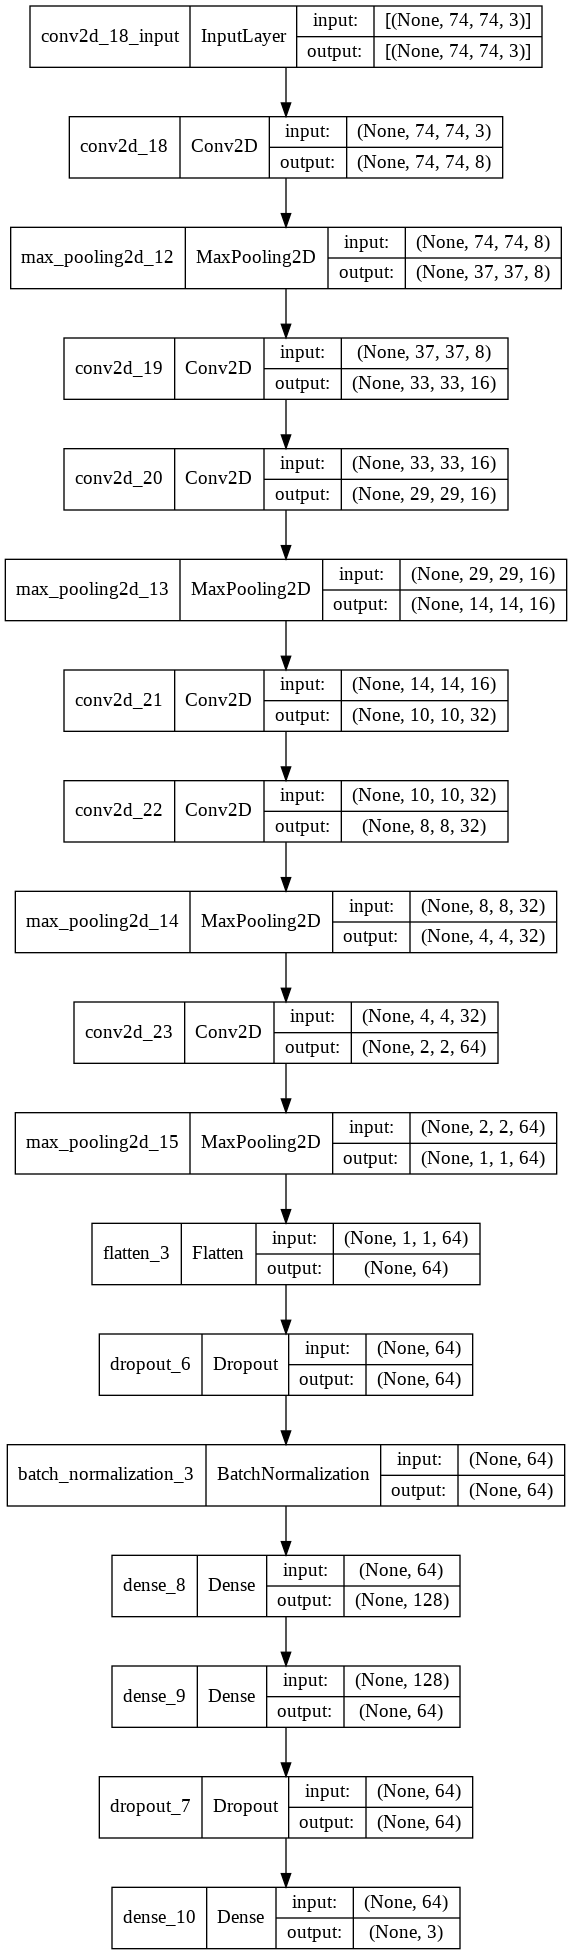

In [ ]:
tf.keras.utils.plot_model(small, show_shapes=True)

In [ ]:
batch = 20
epochs = 100
learnrate = 0.0002

learnDecay = tf.keras.optimizers.schedules.ExponentialDecay(
    learnrate, 100, 0.99
)

In [ ]:
small.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learnDecay), 
    loss = tf.keras.metrics.categorical_crossentropy, 
    metrics = [ 'acc' ]
)

gc.collect()

4937

In [ ]:
small_log = small.fit(
    dmmini.trainSet, dmmini.getTrainLabelsCat(), 
    batch_size = batch, 
    epochs = epochs, 
    verbose = 1,
    validation_data = (dmmini.validSet, dmmini.getValidLabelsCat())
)

Epoch 1/100
250/250 [==============================] - 2s 7ms/step - loss: 1.0987 - acc: 0.3474 - val_loss: 1.0981 - val_acc: 0.3280
Epoch 2/100
250/250 [==============================] - 1s 6ms/step - loss: 1.0599 - acc: 0.4154 - val_loss: 1.0836 - val_acc: 0.3760
Epoch 3/100
250/250 [==============================] - 1s 6ms/step - loss: 0.9876 - acc: 0.4676 - val_loss: 0.9948 - val_acc: 0.4540
Epoch 4/100
250/250 [==============================] - 1s 6ms/step - loss: 0.9358 - acc: 0.5008 - val_loss: 0.9413 - val_acc: 0.5180
Epoch 5/100
250/250 [==============================] - 1s 6ms/step - loss: 0.9098 - acc: 0.5196 - val_loss: 0.8797 - val_acc: 0.5410
Epoch 6/100
250/250 [==============================] - 1s 6ms/step - loss: 0.8723 - acc: 0.5414 - val_loss: 0.9097 - val_acc: 0.5180
Epoch 7/100
250/250 [==============================] - 1s 6ms/step - loss: 0.8477 - acc: 0.5556 - val_loss: 0.8097 - val_acc: 0.5750
Epoch 8/100
250/250 [==============================] - 1s 6ms/step - 

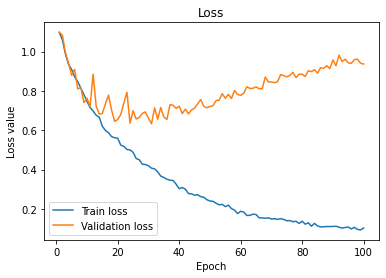

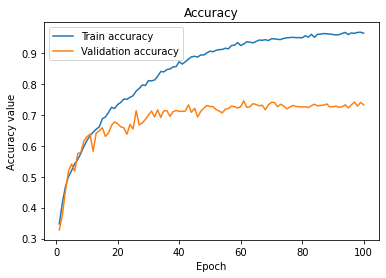

In [ ]:
plotHistory(small_log)

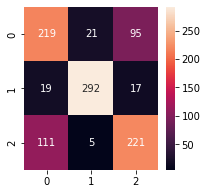

In [ ]:
counts, matches = getMatches(small, dmmini)

In [ ]:
gc.collect()

7823

In [ ]:
small.save("/content/drive/MyDrive/CS4487GP/small.h5")

### Results

Here are the results from one of the early CNN runs:

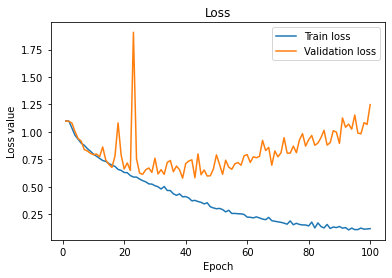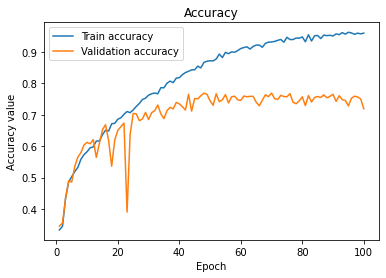

The network showed reasonable results for its simple architecture.

Here is the incidence of mistakes across different classes:

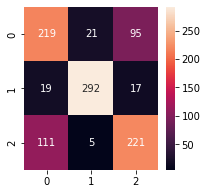

We can see that a majority of the errors were from mixing up `real` and `fake_face2face` images. These are the images where the entirety of a face was transferred to a different person. While these photos might be more recognizable to a human, they actually make less alterations to distinctive facial features, focusing on making the difference between two faces less noticeable. Consequently, the overall `fake_face2face` images are more statistically similar to `real` images (i.e. the individual features look more natural and are more consistent with images of real people), as opposed to `fake_deepfake` images where the individual features are more altered.

Moreover, we can see that the network was slightly overfitted. This means that while it managed to learn some information, it still lacked sufficient data for the given depth and learning rate to notice further patterns.

Therefore, we have shown that patterns can be learned through these networks, and that CNNs can do it effectively. Now, we need to tune the network and adjust the hyperparameters to allow it to do this at a better level.

We can try overlaying ELA on all channels, using the full resolution, and adding depth to seek better performance and tune hyperparameters.

## Custom CNN with ELA I

In [ ]:
def prepareModel(initrate, steps, decay, classes, model):

    modelLoss = tf.keras.metrics.categorical_crossentropy

    if (classes <= 2):
        modelLoss = tf.keras.metrics.binary_crossentropy

    learnDecay = tf.keras.optimizers.schedules.ExponentialDecay(
        initrate, steps, decay
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=learnDecay), 
        loss = modelLoss, 
        metrics = [ 'acc' ]
    )

In [ ]:
def generateCnnModel(initrate, steps, decay, classes):
    activation = 'softmax'

    if (classes <= 2):
        activation = 'sigmoid'
    
    layers = [
        tf.keras.layers.Conv2D(
            8, (5,5), 
            activation = 'relu',
            input_shape = dm.getInputShape()
        ),
        tf.keras.layers.MaxPool2D(
            strides = (2,2),
            padding = 'same'
        ),
        tf.keras.layers.Conv2D(
            16, (5,5), 
            activation = 'relu'
        ),
        tf.keras.layers.MaxPool2D(
            strides = (2,2)
        ),
        tf.keras.layers.Conv2D(
            16, (5,5), 
            activation = 'relu'
        ),
        tf.keras.layers.MaxPool2D(
            strides = (2,2)
        ),
        tf.keras.layers.Conv2D(
            32, (5,5), 
            activation = 'relu'
        ),
        tf.keras.layers.Conv2D(
            32, (3,3), 
            activation = 'relu'
        ),
        tf.keras.layers.MaxPool2D(
            strides = (2,2)
        ),
        tf.keras.layers.Conv2D(
            64, (5,5), 
            activation = 'relu'
        ),
        tf.keras.layers.MaxPool2D(
            strides = (2,2),
            padding = 'same'
        ),
        tf.keras.layers.Conv2D(
            128, (5,5), 
            activation = 'relu'
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            128, 
            activation = 'relu'
        ),
        tf.keras.layers.Dense(
            classes, 
            activation = 'sigmoid'
        )
    ]

    model = tf.keras.models.Sequential(layers)

    prepareModel(initrate, steps, decay, classes, model)

    gc.collect()

    return model

In [ ]:
initrates = np.logspace(-3,-6,5)
decays = [0.96, 0.98, 0.99]
epochs = 40
batch = 20

In [ ]:
results = [[None]*len(decays)]*len(initrates)
gc.collect()

8914

In [ ]:
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


Training for:
  initrate = 0.001
  decay = 0.96
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 41s 337ms/step - loss: 1.0991 - acc: 0.3450 - val_loss: 1.0996 - val_acc: 0.3283
Epoch 2/40
120/120 [==============================] - 40s 337ms/step - loss: 1.0988 - acc: 0.3246 - val_loss: 1.1016 - val_acc: 0.3283
Epoch 3/40
120/120 [==============================] - 40s 333ms/step - loss: 1.0983 - acc: 0.3325 - val_loss: 1.1002 - val_acc: 0.3283
Epoch 4/40
120/120 [==============================] - 40s 331ms/step - loss: 1.0987 - acc: 0.3325 - val_loss: 1.1005 - val_acc: 0.3283
Epoch 5/40
120/120 [==============================] - 40s 330ms/step - loss: 1.0983 - acc: 0.3450 - val_loss: 1.1026 - val_acc: 0.2950
Epoch 6/40
120/120 [==============================] - 40s 331ms/step - loss: 1.0984 - acc: 0.3367 - val_loss: 1.1025 - val_acc: 0.2950
Epoch 7/40
120/120 [==============================] - 40s 331ms/step - loss: 1.0984 - acc: 0.3413 - val

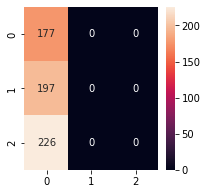

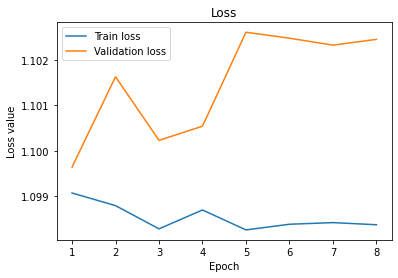

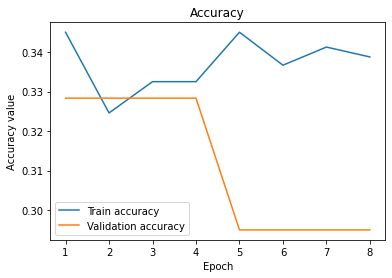


Training for:
  initrate = 0.001
  decay = 0.98
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 40s 328ms/step - loss: 1.0992 - acc: 0.3408 - val_loss: 1.1020 - val_acc: 0.2950
Epoch 2/40
120/120 [==============================] - 39s 325ms/step - loss: 1.0991 - acc: 0.3192 - val_loss: 1.1023 - val_acc: 0.2950
Epoch 3/40
120/120 [==============================] - 39s 326ms/step - loss: 1.0987 - acc: 0.3396 - val_loss: 1.1018 - val_acc: 0.3283
Epoch 4/40
120/120 [==============================] - 39s 326ms/step - loss: 1.0985 - acc: 0.3358 - val_loss: 1.1013 - val_acc: 0.3283
Epoch 5/40
120/120 [==============================] - 39s 325ms/step - loss: 1.0986 - acc: 0.3317 - val_loss: 1.1021 - val_acc: 0.2950
Epoch 6/40
120/120 [==============================] - 39s 325ms/step - loss: 1.0984 - acc: 0.3408 - val_loss: 1.1027 - val_acc: 0.2950
Epoch 7/40
120/120 [==============================] - 39s 326ms/step - loss: 1.0984 - acc: 0.3425 - val

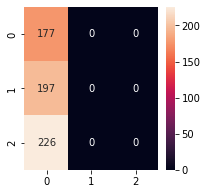

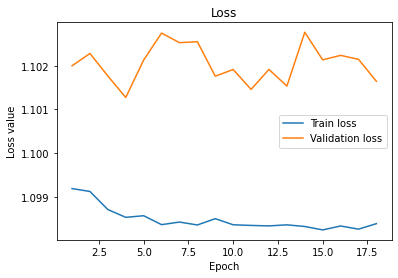

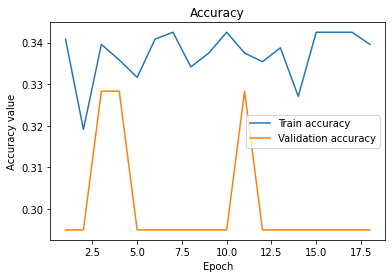


Training for:
  initrate = 0.001
  decay = 0.99
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 40s 329ms/step - loss: 1.0992 - acc: 0.3258 - val_loss: 1.1020 - val_acc: 0.2950
Epoch 2/40
120/120 [==============================] - 39s 323ms/step - loss: 1.0989 - acc: 0.3292 - val_loss: 1.1040 - val_acc: 0.2950
Epoch 3/40
120/120 [==============================] - 39s 324ms/step - loss: 1.0986 - acc: 0.3379 - val_loss: 1.1031 - val_acc: 0.2950
Epoch 4/40
120/120 [==============================] - 39s 327ms/step - loss: 1.0984 - acc: 0.3308 - val_loss: 1.1025 - val_acc: 0.2950
Epoch 5/40
120/120 [==============================] - 39s 326ms/step - loss: 1.0988 - acc: 0.3333 - val_loss: 1.1000 - val_acc: 0.3283
Epoch 6/40
120/120 [==============================] - 39s 327ms/step - loss: 1.0986 - acc: 0.3350 - val_loss: 1.1028 - val_acc: 0.2950
Epoch 7/40
120/120 [==============================] - 39s 329ms/step - loss: 1.0986 - acc: 0.3346 - val

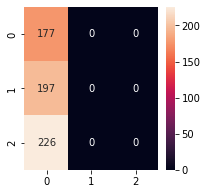

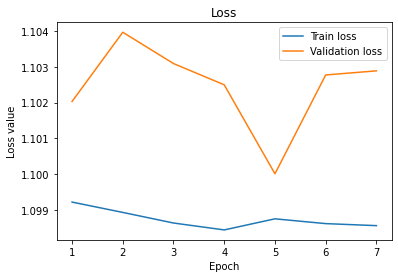

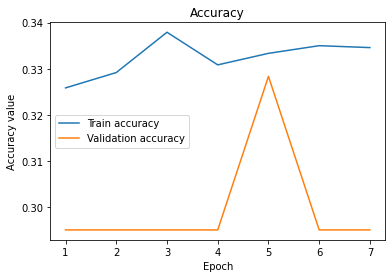


Training for:
  initrate = 0.00017782794100389227
  decay = 0.96
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 40s 325ms/step - loss: 1.0989 - acc: 0.3496 - val_loss: 1.1009 - val_acc: 0.2933
Epoch 2/40
120/120 [==============================] - 38s 320ms/step - loss: 1.0986 - acc: 0.3429 - val_loss: 1.1004 - val_acc: 0.3283
Epoch 3/40
120/120 [==============================] - 38s 320ms/step - loss: 1.0982 - acc: 0.3433 - val_loss: 1.1004 - val_acc: 0.2950
Epoch 4/40
120/120 [==============================] - 38s 320ms/step - loss: 1.0980 - acc: 0.3525 - val_loss: 1.1004 - val_acc: 0.2967
Epoch 5/40
120/120 [==============================] - 38s 320ms/step - loss: 1.0965 - acc: 0.3646 - val_loss: 1.0997 - val_acc: 0.3133
Epoch 6/40
120/120 [==============================] - 38s 320ms/step - loss: 1.0876 - acc: 0.3792 - val_loss: 1.0754 - val_acc: 0.4133
Epoch 7/40
120/120 [==============================] - 38s 320ms/step - loss: 1.0414 - 

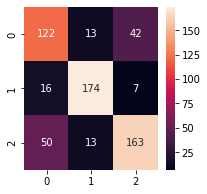

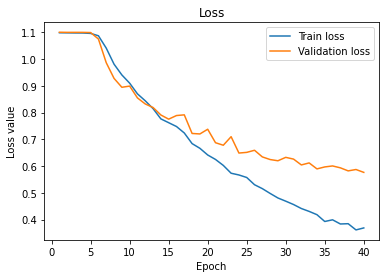

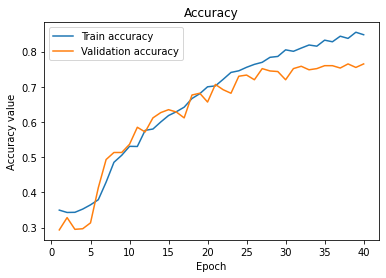


Training for:
  initrate = 0.00017782794100389227
  decay = 0.98
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 40s 331ms/step - loss: 1.0989 - acc: 0.3446 - val_loss: 1.0997 - val_acc: 0.3167
Epoch 2/40
120/120 [==============================] - 39s 327ms/step - loss: 1.0986 - acc: 0.3333 - val_loss: 1.1008 - val_acc: 0.2950
Epoch 3/40
120/120 [==============================] - 39s 328ms/step - loss: 1.0985 - acc: 0.3462 - val_loss: 1.1008 - val_acc: 0.2950
Epoch 4/40
120/120 [==============================] - 39s 327ms/step - loss: 1.0978 - acc: 0.3583 - val_loss: 1.1020 - val_acc: 0.3183
Epoch 5/40
120/120 [==============================] - 39s 327ms/step - loss: 1.0773 - acc: 0.3979 - val_loss: 1.0337 - val_acc: 0.4250
Epoch 6/40
120/120 [==============================] - 39s 328ms/step - loss: 1.0060 - acc: 0.4642 - val_loss: 0.9684 - val_acc: 0.4567
Epoch 7/40
120/120 [==============================] - 39s 328ms/step - loss: 0.9590 - 

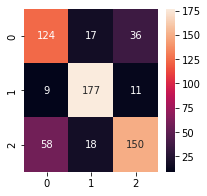

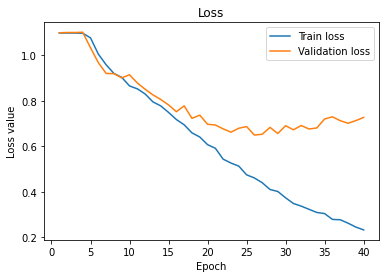

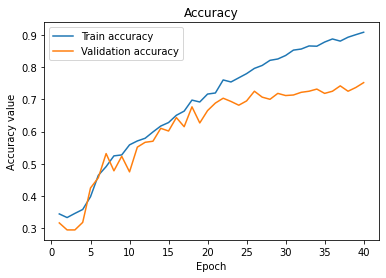


Training for:
  initrate = 0.00017782794100389227
  decay = 0.99
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 41s 336ms/step - loss: 1.0989 - acc: 0.3446 - val_loss: 1.1008 - val_acc: 0.2950
Epoch 2/40
120/120 [==============================] - 40s 333ms/step - loss: 1.0980 - acc: 0.3471 - val_loss: 1.1066 - val_acc: 0.3067
Epoch 3/40
120/120 [==============================] - 40s 334ms/step - loss: 1.0985 - acc: 0.3371 - val_loss: 1.0995 - val_acc: 0.3983
Epoch 4/40
120/120 [==============================] - 40s 336ms/step - loss: 1.0944 - acc: 0.3708 - val_loss: 1.0912 - val_acc: 0.3800
Epoch 5/40
120/120 [==============================] - 40s 335ms/step - loss: 1.0511 - acc: 0.4392 - val_loss: 1.0310 - val_acc: 0.3867
Epoch 6/40
120/120 [==============================] - 41s 339ms/step - loss: 1.0001 - acc: 0.4783 - val_loss: 0.9748 - val_acc: 0.4467
Epoch 7/40
120/120 [==============================] - 40s 336ms/step - loss: 0.9681 - 

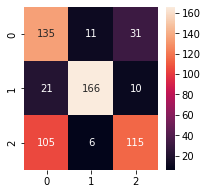

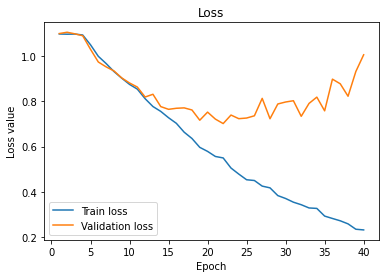

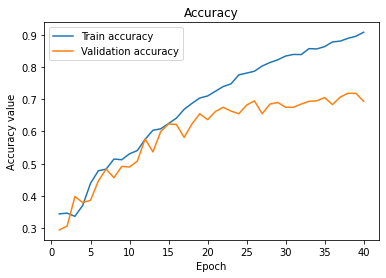


Training for:
  initrate = 3.1622776601683795e-05
  decay = 0.96
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 41s 332ms/step - loss: 1.0986 - acc: 0.3446 - val_loss: 1.1023 - val_acc: 0.2950
Epoch 2/40
120/120 [==============================] - 39s 329ms/step - loss: 1.0981 - acc: 0.3504 - val_loss: 1.1024 - val_acc: 0.2983
Epoch 3/40
120/120 [==============================] - 40s 332ms/step - loss: 1.0973 - acc: 0.3533 - val_loss: 1.1009 - val_acc: 0.3117
Epoch 4/40
120/120 [==============================] - 40s 330ms/step - loss: 1.0973 - acc: 0.3546 - val_loss: 1.0992 - val_acc: 0.3700
Epoch 5/40
120/120 [==============================] - 39s 328ms/step - loss: 1.0960 - acc: 0.3675 - val_loss: 1.1105 - val_acc: 0.2950
Epoch 6/40
120/120 [==============================] - 40s 331ms/step - loss: 1.0970 - acc: 0.3521 - val_loss: 1.1006 - val_acc: 0.3783
Epoch 7/40
120/120 [==============================] - 40s 335ms/step - loss: 1.0955 - 

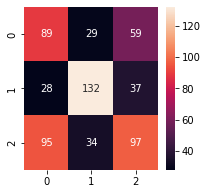

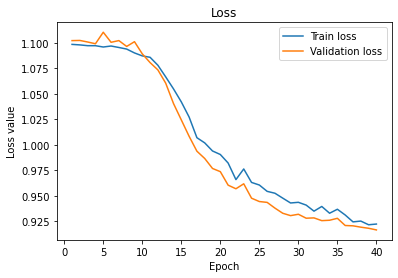

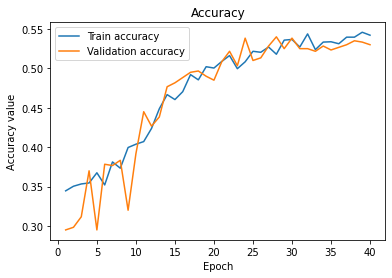


Training for:
  initrate = 3.1622776601683795e-05
  decay = 0.98
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 40s 326ms/step - loss: 1.0980 - acc: 0.3429 - val_loss: 1.1015 - val_acc: 0.2867
Epoch 2/40
120/120 [==============================] - 39s 323ms/step - loss: 1.0986 - acc: 0.3417 - val_loss: 1.1023 - val_acc: 0.2900
Epoch 3/40
120/120 [==============================] - 39s 321ms/step - loss: 1.0976 - acc: 0.3525 - val_loss: 1.1025 - val_acc: 0.3000
Epoch 4/40
120/120 [==============================] - 39s 321ms/step - loss: 1.0988 - acc: 0.3404 - val_loss: 1.1013 - val_acc: 0.3050
Epoch 5/40
120/120 [==============================] - 39s 327ms/step - loss: 1.0960 - acc: 0.3692 - val_loss: 1.1026 - val_acc: 0.3050
Epoch 6/40
120/120 [==============================] - 39s 327ms/step - loss: 1.0970 - acc: 0.3646 - val_loss: 1.1010 - val_acc: 0.3183
Epoch 7/40
120/120 [==============================] - 39s 326ms/step - loss: 1.0955 - 

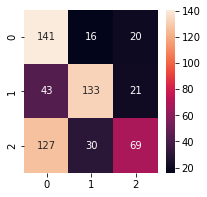

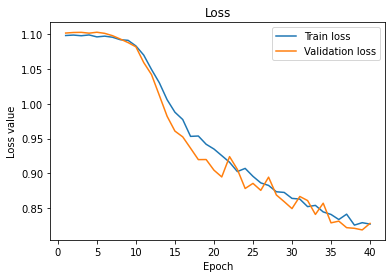

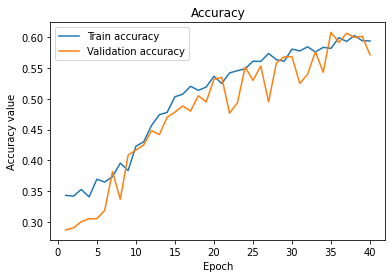


Training for:
  initrate = 3.1622776601683795e-05
  decay = 0.99
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 40s 329ms/step - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0990 - val_acc: 0.2950
Epoch 2/40
120/120 [==============================] - 39s 326ms/step - loss: 1.0982 - acc: 0.3429 - val_loss: 1.0994 - val_acc: 0.2950
Epoch 3/40
120/120 [==============================] - 39s 328ms/step - loss: 1.0978 - acc: 0.3446 - val_loss: 1.1011 - val_acc: 0.2950
Epoch 4/40
120/120 [==============================] - 40s 330ms/step - loss: 1.0972 - acc: 0.3467 - val_loss: 1.1018 - val_acc: 0.2950
Epoch 5/40
120/120 [==============================] - 39s 326ms/step - loss: 1.0954 - acc: 0.3625 - val_loss: 1.1015 - val_acc: 0.3100
Epoch 6/40
120/120 [==============================] - 39s 328ms/step - loss: 1.0918 - acc: 0.3979 - val_loss: 1.0930 - val_acc: 0.4250
Epoch 7/40
120/120 [==============================] - 39s 329ms/step - loss: 1.0819 - 

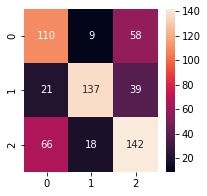

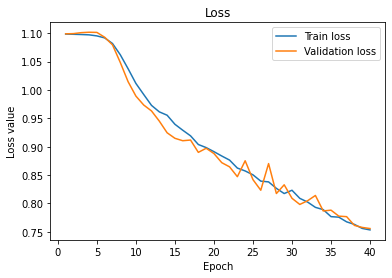

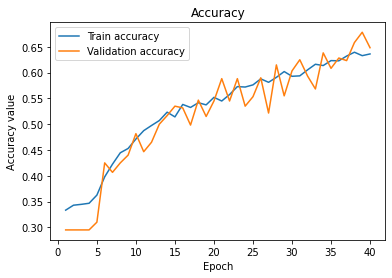


Training for:
  initrate = 5.623413251903491e-06
  decay = 0.96
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 40s 326ms/step - loss: 1.0993 - acc: 0.3096 - val_loss: 1.0983 - val_acc: 0.3767
Epoch 2/40
120/120 [==============================] - 39s 322ms/step - loss: 1.0986 - acc: 0.3408 - val_loss: 1.0987 - val_acc: 0.2967
Epoch 3/40
120/120 [==============================] - 39s 324ms/step - loss: 1.0982 - acc: 0.3500 - val_loss: 1.0989 - val_acc: 0.2983
Epoch 4/40
120/120 [==============================] - 39s 323ms/step - loss: 1.0983 - acc: 0.3433 - val_loss: 1.0992 - val_acc: 0.2967
Epoch 5/40
120/120 [==============================] - 39s 323ms/step - loss: 1.0981 - acc: 0.3537 - val_loss: 1.0992 - val_acc: 0.3017
Epoch 6/40
120/120 [==============================] - 39s 322ms/step - loss: 1.0976 - acc: 0.3558 - val_loss: 1.0993 - val_acc: 0.3017
Epoch 7/40
120/120 [==============================] - 39s 322ms/step - loss: 1.0973 - a

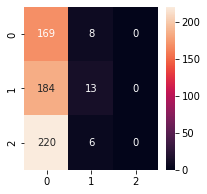

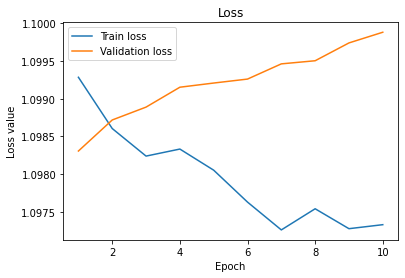

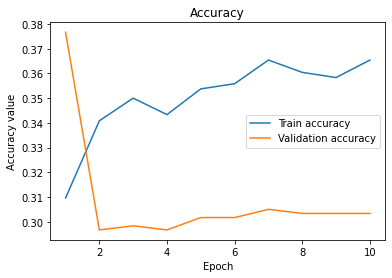


Training for:
  initrate = 5.623413251903491e-06
  decay = 0.98
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 42s 348ms/step - loss: 1.0985 - acc: 0.3396 - val_loss: 1.0995 - val_acc: 0.3283
Epoch 2/40
120/120 [==============================] - 40s 333ms/step - loss: 1.0981 - acc: 0.3400 - val_loss: 1.0996 - val_acc: 0.3283
Epoch 3/40
120/120 [==============================] - 39s 326ms/step - loss: 1.0980 - acc: 0.3433 - val_loss: 1.0998 - val_acc: 0.3283
Epoch 4/40
120/120 [==============================] - 40s 331ms/step - loss: 1.0979 - acc: 0.3454 - val_loss: 1.1000 - val_acc: 0.3300
Epoch 5/40
120/120 [==============================] - 39s 328ms/step - loss: 1.0979 - acc: 0.3487 - val_loss: 1.1002 - val_acc: 0.3600
Epoch 6/40
120/120 [==============================] - 39s 325ms/step - loss: 1.0974 - acc: 0.3592 - val_loss: 1.1005 - val_acc: 0.3567
Epoch 7/40
120/120 [==============================] - 39s 326ms/step - loss: 1.0973 - a

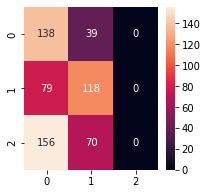

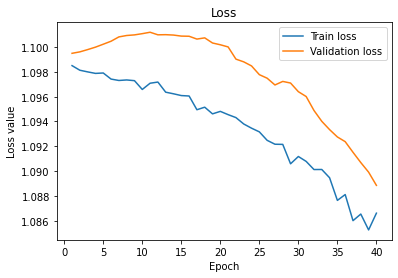

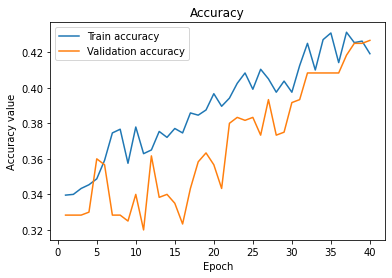


Training for:
  initrate = 5.623413251903491e-06
  decay = 0.99
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 41s 337ms/step - loss: 1.0988 - acc: 0.3262 - val_loss: 1.0985 - val_acc: 0.3050
Epoch 2/40
120/120 [==============================] - 40s 329ms/step - loss: 1.0984 - acc: 0.3400 - val_loss: 1.0988 - val_acc: 0.2950
Epoch 3/40
120/120 [==============================] - 40s 334ms/step - loss: 1.0980 - acc: 0.3542 - val_loss: 1.0992 - val_acc: 0.2950
Epoch 4/40
120/120 [==============================] - 40s 337ms/step - loss: 1.0980 - acc: 0.3517 - val_loss: 1.0994 - val_acc: 0.2950
Epoch 5/40
120/120 [==============================] - 40s 334ms/step - loss: 1.0978 - acc: 0.3546 - val_loss: 1.0996 - val_acc: 0.2950
Epoch 6/40
120/120 [==============================] - 40s 335ms/step - loss: 1.0974 - acc: 0.3583 - val_loss: 1.0998 - val_acc: 0.2967
Epoch 7/40
120/120 [==============================] - 41s 341ms/step - loss: 1.0972 - a

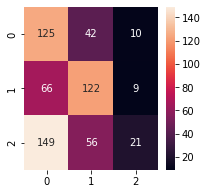

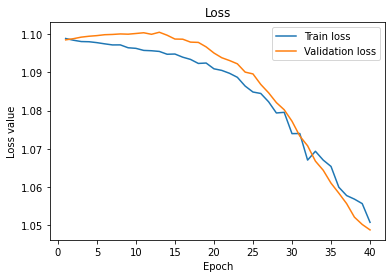

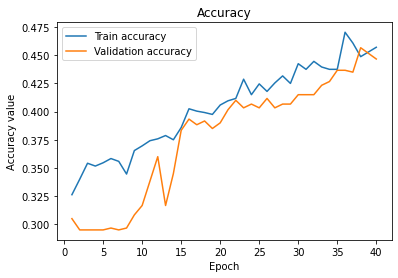


Training for:
  initrate = 1e-06
  decay = 0.96
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 41s 334ms/step - loss: 1.0986 - acc: 0.3262 - val_loss: 1.0986 - val_acc: 0.3300
Epoch 2/40
120/120 [==============================] - 41s 338ms/step - loss: 1.0987 - acc: 0.3125 - val_loss: 1.0986 - val_acc: 0.3200
Epoch 3/40
120/120 [==============================] - 41s 345ms/step - loss: 1.0985 - acc: 0.3379 - val_loss: 1.0986 - val_acc: 0.3017
Epoch 4/40
120/120 [==============================] - 41s 338ms/step - loss: 1.0985 - acc: 0.3288 - val_loss: 1.0987 - val_acc: 0.2983
Epoch 5/40
120/120 [==============================] - 40s 332ms/step - loss: 1.0985 - acc: 0.3550 - val_loss: 1.0987 - val_acc: 0.3050
Epoch 6/40
120/120 [==============================] - 41s 341ms/step - loss: 1.0985 - acc: 0.3308 - val_loss: 1.0987 - val_acc: 0.3050
Epoch 7/40
120/120 [==============================] - 40s 332ms/step - loss: 1.0984 - acc: 0.3429 - val

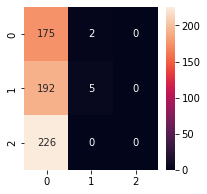

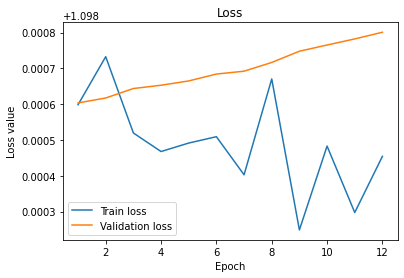

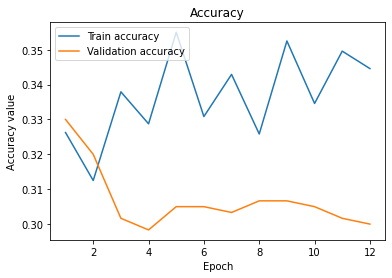


Training for:
  initrate = 1e-06
  decay = 0.98
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 41s 334ms/step - loss: 1.0986 - acc: 0.3413 - val_loss: 1.0985 - val_acc: 0.3317
Epoch 2/40
120/120 [==============================] - 40s 330ms/step - loss: 1.0987 - acc: 0.3338 - val_loss: 1.0985 - val_acc: 0.3517
Epoch 3/40
120/120 [==============================] - 40s 332ms/step - loss: 1.0985 - acc: 0.3371 - val_loss: 1.0986 - val_acc: 0.3433
Epoch 4/40
120/120 [==============================] - 40s 331ms/step - loss: 1.0988 - acc: 0.3217 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/40
120/120 [==============================] - 40s 333ms/step - loss: 1.0985 - acc: 0.3350 - val_loss: 1.0986 - val_acc: 0.3367
Epoch 6/40
120/120 [==============================] - 40s 330ms/step - loss: 1.0986 - acc: 0.3438 - val_loss: 1.0987 - val_acc: 0.3500
Epoch 7/40
120/120 [==============================] - 39s 329ms/step - loss: 1.0985 - acc: 0.3442 - val

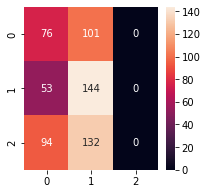

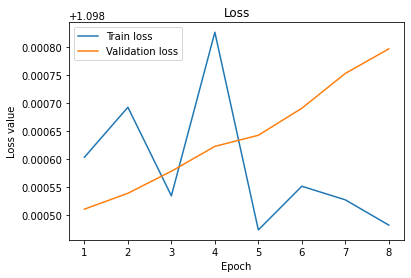

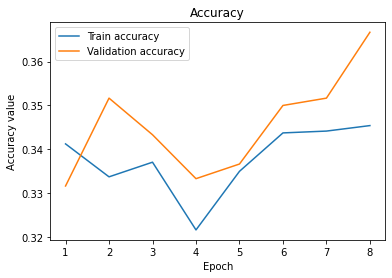


Training for:
  initrate = 1e-06
  decay = 0.99
Up to 40 epochs with early stopping.

Epoch 1/40
120/120 [==============================] - 41s 335ms/step - loss: 1.0993 - acc: 0.3317 - val_loss: 1.0985 - val_acc: 0.3700
Epoch 2/40
120/120 [==============================] - 40s 330ms/step - loss: 1.0984 - acc: 0.3438 - val_loss: 1.0985 - val_acc: 0.3417
Epoch 3/40
120/120 [==============================] - 40s 336ms/step - loss: 1.0990 - acc: 0.3150 - val_loss: 1.0986 - val_acc: 0.3467
Epoch 4/40
120/120 [==============================] - 40s 331ms/step - loss: 1.0982 - acc: 0.3533 - val_loss: 1.0986 - val_acc: 0.3067
Epoch 5/40
120/120 [==============================] - 40s 333ms/step - loss: 1.0987 - acc: 0.3408 - val_loss: 1.0987 - val_acc: 0.2917
Epoch 6/40
120/120 [==============================] - 40s 332ms/step - loss: 1.0986 - acc: 0.3346 - val_loss: 1.0987 - val_acc: 0.3033
Epoch 7/40
120/120 [==============================] - 40s 333ms/step - loss: 1.0980 - acc: 0.3529 - val

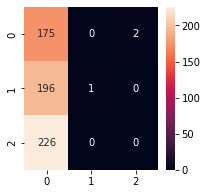

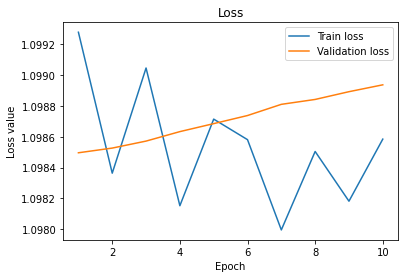

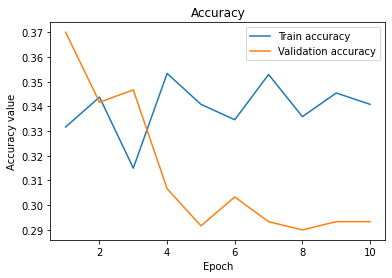

In [ ]:
for i,initrate in enumerate(initrates):
    for j,decay in enumerate(decays):
        model = generateCnnModel(initrate,100,decay,3)

        print()
        print("Training for:")
        print("  initrate = {}".format(initrate))
        print("  decay = {}".format(decay))
        print("Up to {} epochs with early stopping.".format(epochs))
        print()

        log = model.fit(
            dm.trainSet, dm.getTrainLabelsCat(), 
            batch_size = batch, 
            epochs = epochs, 
            verbose = 1,
            validation_data = (dm.validSet, dm.getValidLabelsCat()),
            callbacks = [ earlyStopCallback ]
        )

        counts, matches = getMatches(model, dm)

        results[i][j] = {
            "initrate": initrate,
            "decay": decay,
            "epochs": epochs,
            "log": log,
            "counts": counts,
            "matches": matches
        }

        model.save("/content/drive/MyDrive/CS4487GP/cnn-{}-{}.h5".format(i,j))
        plotHistory(log)

        gc.collect()

In [ ]:
gc.collect()

In [ ]:
print(results)

The best validation results were achieved for: 

```
  initrate = 0.00017782794100389227
  decay = 0.98
```

We managed to get **75.17%** 3-class classification error, and **0.7272** loss. When converted into a binary classifier (`real` vs `fake`), the accuracy becomes **80.00%** for this model. We can see that most of the mislabelings happen on `real` and `fake_face2face` mislabelings.

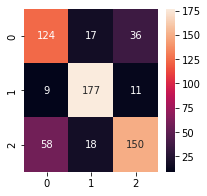

However, another issue that we might notice is that the network starts overfitting after a while. It is slightly less noticable than in the first run, but we can still improve this by extracting a bit more features through convolution and adding a dense layer for more advanced extrapolation from features. While the hyperparameter settings won't still apply, we can expect good values to be close to the ones performing well on this model.

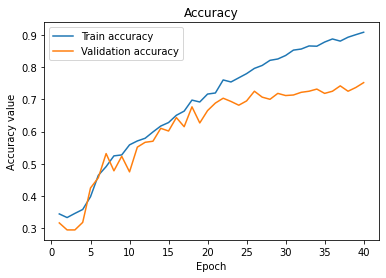
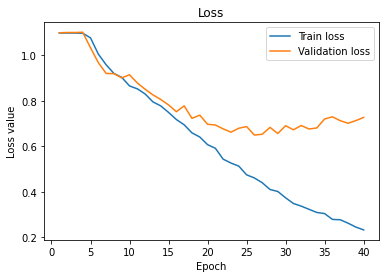

## Custom CNN with ELA II



In [ ]:
def generateCnn2Model(initrate, steps, decay, classes):
    activation = 'softmax'

    if (classes <= 2):
        activation = 'sigmoid'
    
    layers = [
        tf.keras.layers.Conv2D(
            16, (5,5), 
            activation = 'relu',
            input_shape = dm.getInputShape()
        ),
        tf.keras.layers.MaxPool2D(
            strides = (2,2),
            padding = 'same'
        ),
        tf.keras.layers.Conv2D(
            24, (5,5), 
            activation = 'relu'
        ),
        tf.keras.layers.MaxPool2D(
            strides = (2,2)
        ),
        tf.keras.layers.Conv2D(
            32, (5,5), 
            activation = 'relu'
        ),
        tf.keras.layers.MaxPool2D(
            strides = (2,2)
        ),
        tf.keras.layers.Conv2D(
            64, (5,5), 
            activation = 'relu'
        ),
        tf.keras.layers.Conv2D(
            96, (3,3), 
            activation = 'relu'
        ),
        tf.keras.layers.MaxPool2D(
            strides = (2,2)
        ),
        tf.keras.layers.Conv2D(
            128, (5,5), 
            activation = 'relu'
        ),
        tf.keras.layers.MaxPool2D(
            strides = (2,2),
            padding = 'same'
        ),
        tf.keras.layers.Conv2D(
            256, (5,5), 
            activation = 'relu'
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            256, 
            activation = 'relu'
        ),
        tf.keras.layers.Dense(
            128, 
            activation = 'relu'
        ),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(
            classes, 
            activation = 'sigmoid'
        )
    ]

    model = tf.keras.models.Sequential(layers)

    prepareModel(initrate, steps, decay, classes, model)

    gc.collect()

    return model

In [ ]:
initrates = np.logspace(-3.5,-4,3)
decays = [0.975, 0.98, 0.985]
epochs = 80
batch = 20

In [ ]:
results = [[None]*len(decays)]*len(initrates)
gc.collect()

533

In [ ]:
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


Training CNN II for:
  initrate = 0.00031622776601683794
  decay = 0.975
Up to 80 epochs with early stopping.

Epoch 1/80
150/150 [==============================] - 15s 39ms/step - loss: 1.0994 - acc: 0.3280 - val_loss: 1.0988 - val_acc: 0.3227
Epoch 2/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3333 - val_loss: 1.0989 - val_acc: 0.3227
Epoch 3/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3380 - val_loss: 1.0987 - val_acc: 0.3227
Epoch 4/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3243 - val_loss: 1.0989 - val_acc: 0.3227
Epoch 5/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3350 - val_loss: 1.0989 - val_acc: 0.3227
Epoch 6/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0985 - acc: 0.3377 - val_loss: 1.0990 - val_acc: 0.3227
Epoch 7/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0989 - acc: 

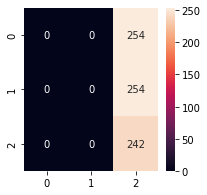

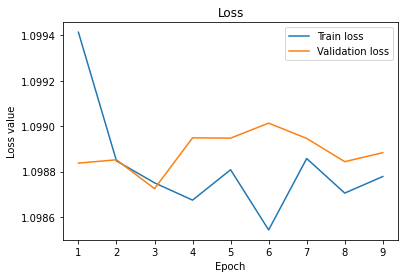

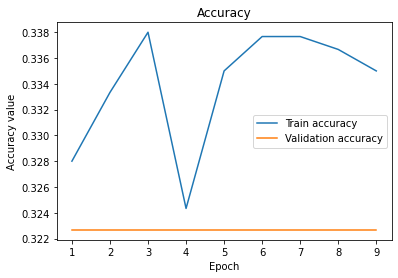


Training CNN II for:
  initrate = 0.00031622776601683794
  decay = 0.98
Up to 80 epochs with early stopping.

Epoch 1/80
150/150 [==============================] - 7s 43ms/step - loss: 1.0994 - acc: 0.3223 - val_loss: 1.0987 - val_acc: 0.3387
Epoch 2/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0989 - acc: 0.3163 - val_loss: 1.0988 - val_acc: 0.3227
Epoch 3/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3213 - val_loss: 1.0989 - val_acc: 0.3227
Epoch 4/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3340 - val_loss: 1.0990 - val_acc: 0.3227
Epoch 5/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3237 - val_loss: 1.0989 - val_acc: 0.3227
Epoch 6/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3293 - val_loss: 1.0989 - val_acc: 0.3227
Epoch 7/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.

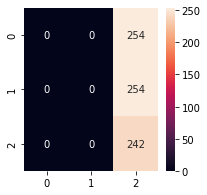

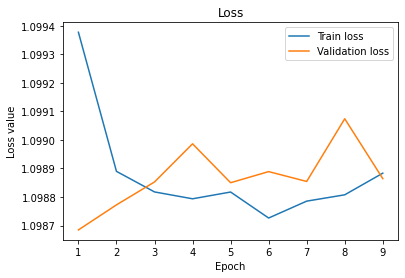

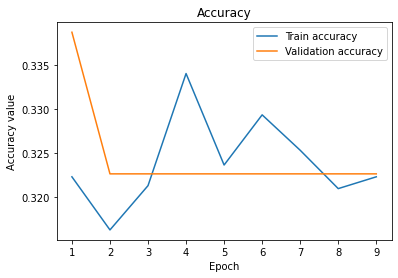


Training CNN II for:
  initrate = 0.00031622776601683794
  decay = 0.985
Up to 80 epochs with early stopping.

Epoch 1/80
150/150 [==============================] - 7s 42ms/step - loss: 1.0993 - acc: 0.3300 - val_loss: 1.0986 - val_acc: 0.3387
Epoch 2/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0986 - acc: 0.3317 - val_loss: 1.0988 - val_acc: 0.3227
Epoch 3/80
150/150 [==============================] - 5s 35ms/step - loss: 1.0990 - acc: 0.3340 - val_loss: 1.0987 - val_acc: 0.3387
Epoch 4/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3367 - val_loss: 1.0990 - val_acc: 0.3227
Epoch 5/80
150/150 [==============================] - 5s 35ms/step - loss: 1.0990 - acc: 0.3260 - val_loss: 1.0987 - val_acc: 0.3227


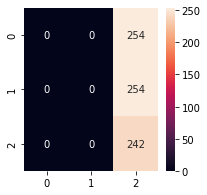

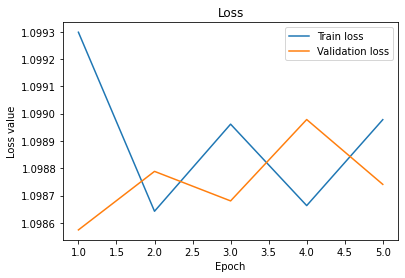

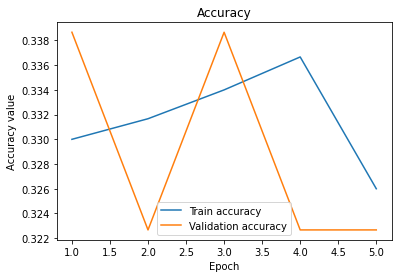


Training CNN II for:
  initrate = 0.00017782794100389227
  decay = 0.975
Up to 80 epochs with early stopping.

Epoch 1/80
150/150 [==============================] - 7s 41ms/step - loss: 1.0992 - acc: 0.3447 - val_loss: 1.0985 - val_acc: 0.3387
Epoch 2/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0989 - acc: 0.3340 - val_loss: 1.0987 - val_acc: 0.3227
Epoch 3/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3400 - val_loss: 1.0988 - val_acc: 0.3227
Epoch 4/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3413 - val_loss: 1.0989 - val_acc: 0.3227
Epoch 5/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3293 - val_loss: 1.0988 - val_acc: 0.3227
Epoch 6/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3327 - val_loss: 1.0989 - val_acc: 0.3227
Epoch 7/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0

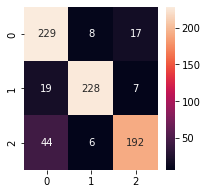

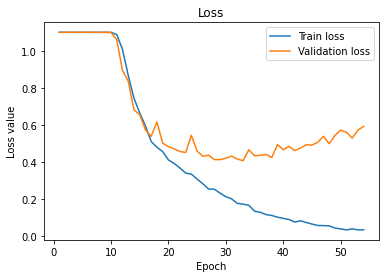

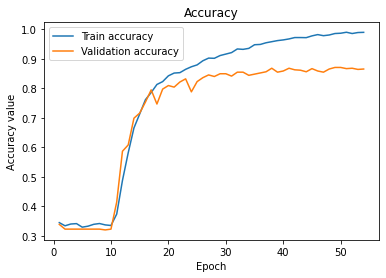


Training CNN II for:
  initrate = 0.00017782794100389227
  decay = 0.98
Up to 80 epochs with early stopping.

Epoch 1/80
150/150 [==============================] - 7s 41ms/step - loss: 1.0991 - acc: 0.3457 - val_loss: 1.0991 - val_acc: 0.3227
Epoch 2/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0989 - acc: 0.3377 - val_loss: 1.0989 - val_acc: 0.3227
Epoch 3/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3273 - val_loss: 1.0988 - val_acc: 0.3227
Epoch 4/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3357 - val_loss: 1.0989 - val_acc: 0.3227
Epoch 5/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0989 - acc: 0.3250 - val_loss: 1.0988 - val_acc: 0.3227
Epoch 6/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3407 - val_loss: 1.0989 - val_acc: 0.3227
Epoch 7/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.

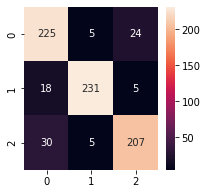

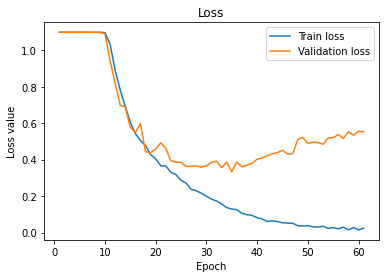

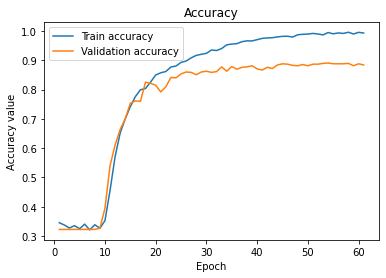


Training CNN II for:
  initrate = 0.00017782794100389227
  decay = 0.985
Up to 80 epochs with early stopping.

Epoch 1/80
150/150 [==============================] - 7s 41ms/step - loss: 1.0990 - acc: 0.3400 - val_loss: 1.0991 - val_acc: 0.3227
Epoch 2/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0990 - acc: 0.3343 - val_loss: 1.0987 - val_acc: 0.3227
Epoch 3/80
150/150 [==============================] - 5s 33ms/step - loss: 1.0989 - acc: 0.3437 - val_loss: 1.0985 - val_acc: 0.3227
Epoch 4/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0976 - acc: 0.3520 - val_loss: 1.0904 - val_acc: 0.3387
Epoch 5/80
150/150 [==============================] - 5s 33ms/step - loss: 1.0639 - acc: 0.4287 - val_loss: 0.9788 - val_acc: 0.5013
Epoch 6/80
150/150 [==============================] - 5s 34ms/step - loss: 0.9458 - acc: 0.5157 - val_loss: 0.8659 - val_acc: 0.5920
Epoch 7/80
150/150 [==============================] - 5s 34ms/step - loss: 0.8136 - acc: 0

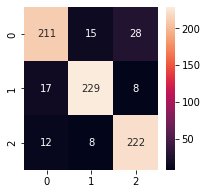

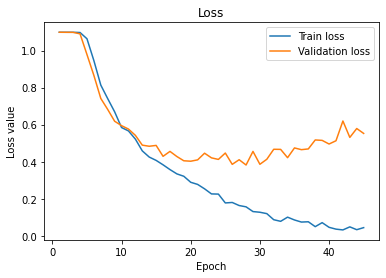

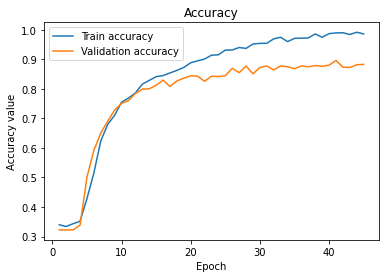


Training CNN II for:
  initrate = 0.0001
  decay = 0.975
Up to 80 epochs with early stopping.

Epoch 1/80
150/150 [==============================] - 7s 41ms/step - loss: 1.0990 - acc: 0.3230 - val_loss: 1.0987 - val_acc: 0.3227
Epoch 2/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3363 - val_loss: 1.0987 - val_acc: 0.3227
Epoch 3/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0989 - acc: 0.3420 - val_loss: 1.0987 - val_acc: 0.3227
Epoch 4/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3303 - val_loss: 1.0985 - val_acc: 0.3880
Epoch 5/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0983 - acc: 0.3487 - val_loss: 1.0959 - val_acc: 0.3853
Epoch 6/80
150/150 [==============================] - 5s 35ms/step - loss: 1.0701 - acc: 0.4143 - val_loss: 0.9699 - val_acc: 0.5093
Epoch 7/80
150/150 [==============================] - 5s 34ms/step - loss: 0.9064 - acc: 0.5543 - val_loss

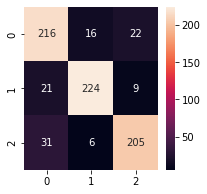

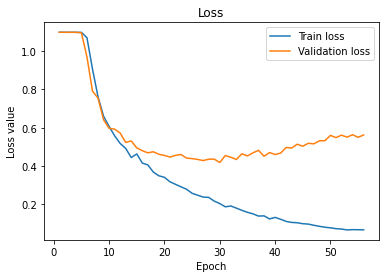

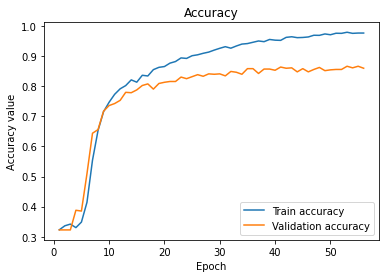


Training CNN II for:
  initrate = 0.0001
  decay = 0.98
Up to 80 epochs with early stopping.

Epoch 1/80
150/150 [==============================] - 7s 41ms/step - loss: 1.0990 - acc: 0.3400 - val_loss: 1.0986 - val_acc: 0.3213
Epoch 2/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0989 - acc: 0.3257 - val_loss: 1.0988 - val_acc: 0.3227
Epoch 3/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3343 - val_loss: 1.0988 - val_acc: 0.3227
Epoch 4/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3347 - val_loss: 1.0987 - val_acc: 0.3227
Epoch 5/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3207 - val_loss: 1.0987 - val_acc: 0.3227
Epoch 6/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3350 - val_loss: 1.0987 - val_acc: 0.3227
Epoch 7/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3227 - val_loss:

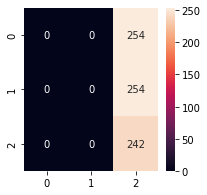

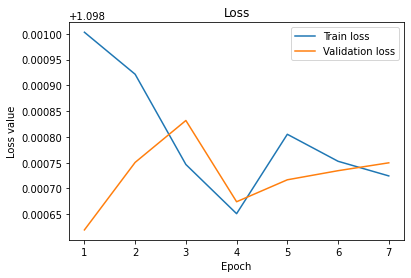

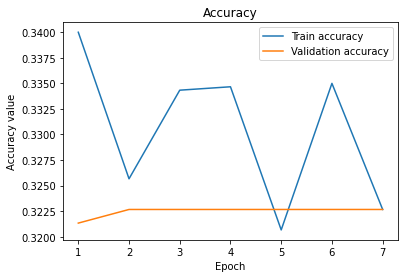


Training CNN II for:
  initrate = 0.0001
  decay = 0.985
Up to 80 epochs with early stopping.

Epoch 1/80
150/150 [==============================] - 7s 41ms/step - loss: 1.0989 - acc: 0.3307 - val_loss: 1.0986 - val_acc: 0.3387
Epoch 2/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0988 - acc: 0.3157 - val_loss: 1.0986 - val_acc: 0.3227
Epoch 3/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0987 - acc: 0.3380 - val_loss: 1.0985 - val_acc: 0.3587
Epoch 4/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0984 - acc: 0.3410 - val_loss: 1.1004 - val_acc: 0.3227
Epoch 5/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0985 - acc: 0.3487 - val_loss: 1.0968 - val_acc: 0.3533
Epoch 6/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0892 - acc: 0.3767 - val_loss: 1.0665 - val_acc: 0.4173
Epoch 7/80
150/150 [==============================] - 5s 34ms/step - loss: 1.0456 - acc: 0.4597 - val_loss

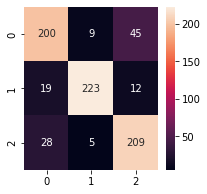

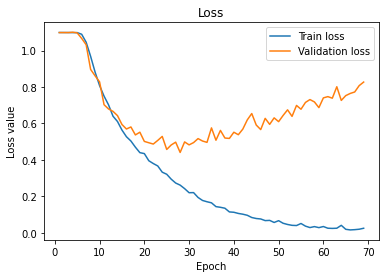

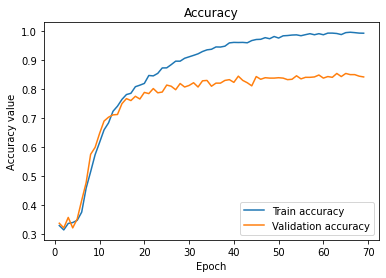

In [ ]:
for i,initrate in enumerate(initrates):
    for j,decay in enumerate(decays):
        model = generateCnn2Model(initrate,100,decay,3)

        print()
        print("Training CNN II for:")
        print("  initrate = {}".format(initrate))
        print("  decay = {}".format(decay))
        print("Up to {} epochs with early stopping.".format(epochs))
        print()

        log = model.fit(
            dm.trainSet, dm.getTrainLabelsCat(), 
            batch_size = batch, 
            epochs = epochs, 
            verbose = 1,
            validation_data = (dm.validSet, dm.getValidLabelsCat()),
            callbacks = [ earlyStopCallback ]
        )

        counts, matches = getMatches(model, dm)

        results[i][j] = {
            "initrate": initrate,
            "decay": decay,
            "epochs": epochs,
            "log": log,
            "counts": counts,
            "matches": matches
        }

        model.save("/content/drive/MyDrive/CS4487GP/cnn2-{}-{}.h5".format(i,j))
        plotHistory(log)

        gc.collect()

In [ ]:
print(results)

[[{'initrate': 0.0001, 'decay': 0.975, 'epochs': 80, 'log': <keras.callbacks.History object at 0x7fe0e67b5510>, 'counts': array([[216,  16,  22],
       [ 21, 224,   9],
       [ 31,   6, 205]], dtype=int32), 'matches': [(0, 1, 1), (1, 2, 2), (2, 1, 1), (3, 2, 1), (4, 2, 2), (5, 1, 1), (6, 0, 0), (7, 2, 0), (8, 1, 1), (9, 1, 1), (10, 1, 2), (11, 0, 0), (12, 1, 1), (13, 0, 0), (14, 2, 2), (15, 2, 0), (16, 1, 1), (17, 2, 2), (18, 0, 2), (19, 0, 0), (20, 1, 1), (21, 1, 1), (22, 1, 1), (23, 2, 2), (24, 0, 0), (25, 2, 2), (26, 1, 1), (27, 0, 0), (28, 2, 2), (29, 2, 2), (30, 0, 0), (31, 1, 1), (32, 2, 0), (33, 1, 1), (34, 1, 1), (35, 2, 2), (36, 1, 1), (37, 0, 1), (38, 2, 2), (39, 0, 0), (40, 1, 0), (41, 1, 1), (42, 0, 0), (43, 0, 0), (44, 1, 1), (45, 2, 2), (46, 2, 1), (47, 1, 1), (48, 1, 1), (49, 0, 0), (50, 0, 0), (51, 1, 1), (52, 0, 0), (53, 1, 1), (54, 1, 0), (55, 2, 2), (56, 1, 0), (57, 0, 0), (58, 0, 0), (59, 2, 0), (60, 2, 2), (61, 2, 2), (62, 1, 1), (63, 2, 1), (64, 0, 2), (65, 0, 2

This time, the best performing parameters were:

```
Training CNN II for:
  initrate = 0.00017782794100389227
  decay = 0.98
Up to 80 epochs with early stopping.
```

The errors were mostly the same, and for the same causes, but occured less frequently.

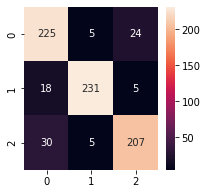

It also started overfitting after validation accuracy reached 80-85%.

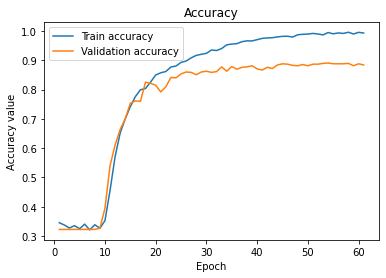
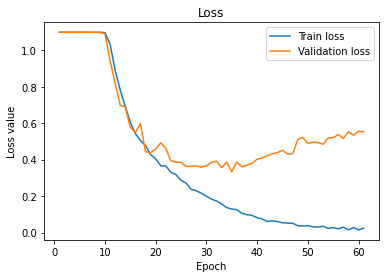

This is a very good result for a classical CNN. With additional resources, the complexity could be increased further (mostly by increasing depth and width), to achieve an even better result.

## Custom CNN with ELA III

**(Warning! Please restart the kernel!)**

Environment: Google Colab Keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
'''
  I assume folders [real, fake_deepfake, fake_face2face] exist in this directory
'''
cd /content/drive/MyDrive/CSML

In [ ]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add, Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Activation, Rescaling, SeparableConv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools


In [ ]:
def convert_to_ela_image(path, quality, isArray=False, array=[]):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    if isArray:
      image = Image.fromarray(array)
    else:
      image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [ ]:
# See the difference between compressed and uncompressed images
real_image_path = './real/3000.png'
plt.imshow(Image.open(real_image_path))
plt.imshow(convert_to_ela_image(real_image_path, 70))
deepfake_image_path = './fake_deepfake/3000.png'
plt.imshow(Image.open(deepfake_image_path))
plt.imshow(convert_to_ela_image(deepfake_image_path, 70))

FileNotFoundError: ignored

In [ ]:
from skimage.io import imread_collection

# ELA images
X = np.empty((12000, 128, 128, 3))
# 0 fake, 1 real
Y = np.concatenate([np.zeros((8000,), dtype=int), np.ones((4000,), dtype=int)], axis=None)

image_size = (128, 128)
counter = 0

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)) / 255.0

path_fake_face2face = "/content/drive/MyDrive/CSML/fake_face2face/"
for dirname, _, filenames in os.walk(path_fake_face2face):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)

            X[counter] = prepare_image(full_path)
            if counter % 500 == 0:
                print(f'processed {counter} images')
            counter+=1

path_fake_deepfake = "/content/drive/MyDrive/CSML/fake_deepfake/"
for dirname, _, filenames in os.walk(path_fake_deepfake):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)

            X[counter] = prepare_image(full_path)
            if counter % 500 == 0:
                print(f'processed {counter} images')
            counter+=1

path_fake_real = "/content/drive/MyDrive/CSML/real/"
for dirname, _, filenames in os.walk(path_fake_deepfake):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)

            X[counter] = prepare_image(full_path)
            if counter % 500 == 0:
                print(f'processed {counter} images')
            counter+=1

'''
# This was used to save time 

small_images = np.load("small_images.npy")  

# data preprocessing
def ela_from_array(arr):
  return np.array(convert_to_ela_image("", 90, isArray = True, array=arr))

# ELA images
X = np.empty((12000, 128, 128, 3))
# 0 fake, 1 real
Y = np.concatenate([np.zeros((8000,), dtype=int), np.ones((4000,), dtype=int)], axis=None)
for i in range(12000):
  X[i] = ela_from_array(small_images[i])
  if i % 500 == 0:
    print(f'processed {i} images')

'''


'\n# This was used to save time \n\nsmall_images = np.load("small_images.npy")  \n\n# data preprocessing\ndef ela_from_array(arr):\n  return np.array(convert_to_ela_image("", 90, isArray = True, array=arr))\n\n# ELA images\nX = np.empty((12000, 128, 128, 3))\n# 0 fake, 1 real\nY = np.concatenate([np.zeros((8000,), dtype=int), np.ones((4000,), dtype=int)], axis=None)\nfor i in range(12000):\n  X[i] = ela_from_array(small_images[i])\n  if i % 500 == 0:\n    print(f\'processed {i} images\')\n\n'

In [ ]:
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=0)
# X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))


# free up some space if needed
# del small_images
# del X


In [ ]:
# Custom CNN (without pretrained models)

def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        25632     
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0

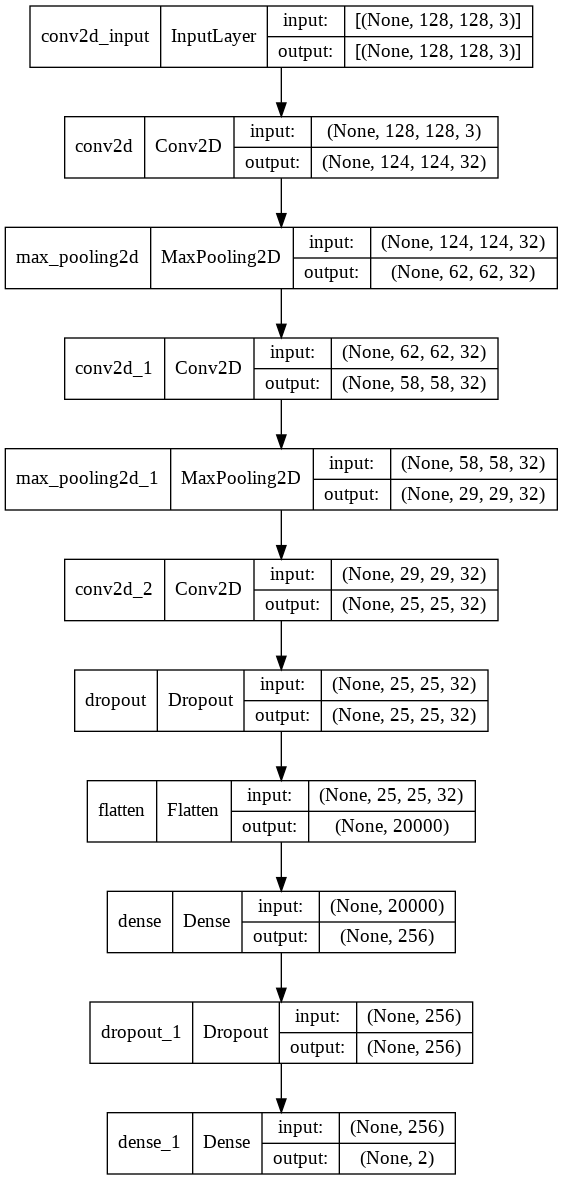

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 32
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr) 
model.compile(
    optimizer = optimizer, 
    loss = 'binary_crossentropy', 
    metrics = ['accuracy']
    )
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_val, Y_val),
                #  callbacks = [early_stopping]
                 )
model.save('model_ela_cnn_di_run1.h5')


Epoch 1/100
300/300 [==============================] - 4s 12ms/step - loss: 0.3555 - accuracy: 0.8445 - val_loss: 0.5409 - val_accuracy: 0.7342
Epoch 2/100
300/300 [==============================] - 3s 11ms/step - loss: 0.3296 - accuracy: 0.8568 - val_loss: 0.5455 - val_accuracy: 0.7321
Epoch 3/100
300/300 [==============================] - 3s 11ms/step - loss: 0.2902 - accuracy: 0.8782 - val_loss: 0.5661 - val_accuracy: 0.7304
Epoch 4/100
300/300 [==============================] - 3s 11ms/step - loss: 0.2673 - accuracy: 0.8902 - val_loss: 0.5480 - val_accuracy: 0.7362
Epoch 5/100
300/300 [==============================] - 3s 11ms/step - loss: 0.2292 - accuracy: 0.9075 - val_loss: 0.5509 - val_accuracy: 0.7454
Epoch 6/100
300/300 [==============================] - 3s 11ms/step - loss: 0.1906 - accuracy: 0.9230 - val_loss: 0.5917 - val_accuracy: 0.7462
Epoch 7/100
300/300 [==============================] - 3s 11ms/step - loss: 0.1889 - accuracy: 0.9256 - val_loss: 0.7330 - val_accuracy:

In [ ]:
model.save('model_ela_cnn_di_run1.h5')

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Below is the image with graphs representing the training from previous run.

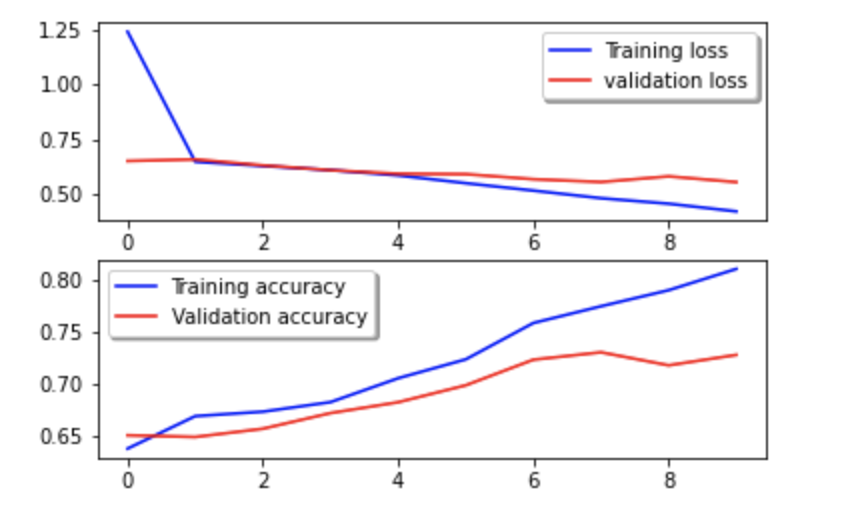

## Xception

In the next experiment I have used Xception.

Since the image sizes were 299x299 and Xception's input is also 299x299, I have high expectations about this model's performance. During the presentations of other teams we have noticed that models with ImageNet pretrained layers perfomed the best. Because of this fact we have shifted from implementing an active learning to training Xception (with pretrained layers) for our dataset instead.

Below is the architechture of Xception visualised via Keras (PyTorch will be used for training):

83697664/83683744 [==============================] - 1s 0us/step


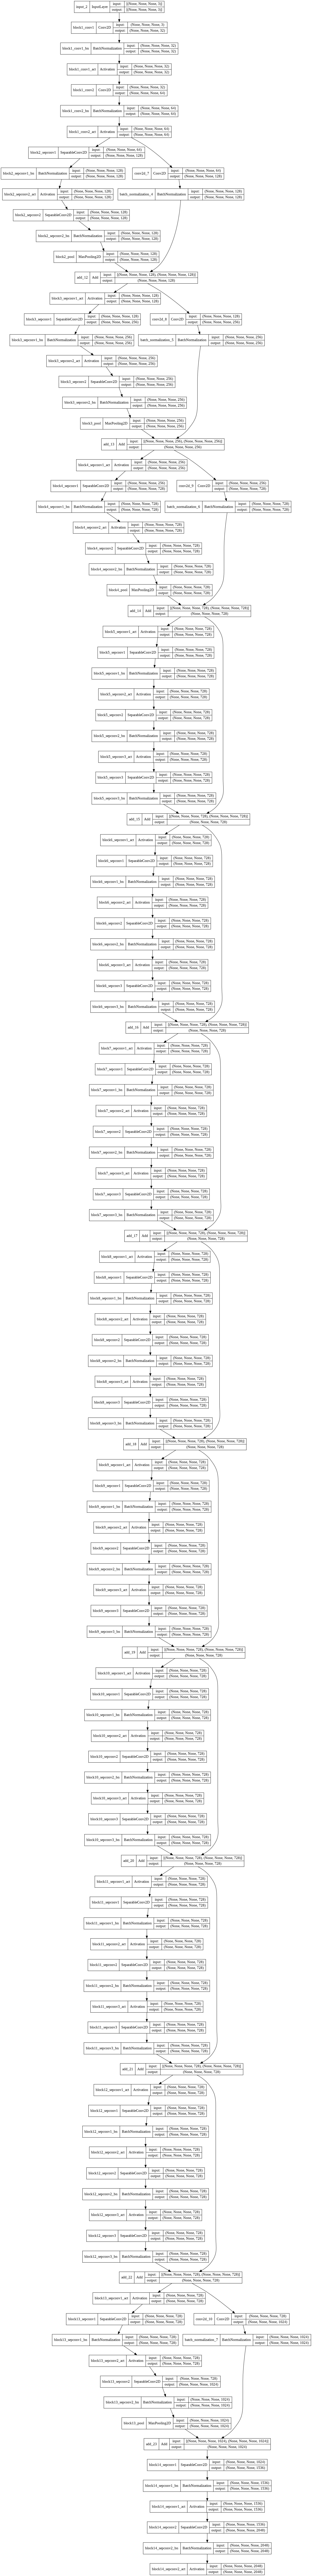

In [ ]:
import tensorflow as tf

# Below graph is just for illustation purposes
# all layers apart from the last layer will be identical to the graph below

model = tf.keras.applications.Xception(
    include_top=False,
    # weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

# The final experiment Xception with Imagenet pretrained layers [Warning! Please restart the kernel!]
Environment: Windows with CUDA, FYP computer with NVIDIA GeForce RTX 2080 Ti

In [ ]:
import torch
import json
from PIL import Image
import torch.nn as nn
from torchvision import transforms
import torchvision.transforms.functional as F
import os
import pandas as pd
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pretrainedmodels
from torchviz import make_dot
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

# see if GPU is available, tested on RTX 2080 TI
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")
print("device available:",device)
if torch.cuda.is_available():
    print("GPU available:",torch.cuda.get_device_name(0))

imageSize = 299
logInterval = 10
lossScaler = 10
batchSize = 32 # fits in FYP comuter, smaller for Google Colab

rootPath = 'C:/Users/ibatyrbek2/Desktop/CSML/' # change to root directory
dataDirNames = ['fake_deepfake', 'fake_face2face', 'real']

In [ ]:
def getLabel(ddn): # fake: 1, real： 0
    if ddn == 'real':
        return 0
    return 1

def makeSplitCsv():
    for ddn in dataDirNames:
        datasetPath = rootPath + ddn + '/'
        imgNames = os.listdir(datasetPath)
        npDirs = np.full([len(imgNames),1], ddn + '/')
        npFileNames = np.array(imgNames).reshape(-1,1)
        npLabels = np.full([len(imgNames),1], getLabel(ddn))
        npDataset = np.hstack([npDirs,npFileNames,npLabels])
        pd.DataFrame(npDataset, columns=['path','file_name','label']).to_csv(ddn +'.csv', index=False)
    
    dfMergedDatasets = pd.read_csv('fake_deepfake.csv').append(pd.read_csv('fake_face2face.csv')).append(pd.read_csv('real.csv')).reset_index(drop=True)
    
    dfTrain, dfTest = train_test_split(dfMergedDatasets, test_size=0.2) # best result when 20% is test(validation)

    dfTest.to_csv('split_test.csv', index=False)
    dfTrain.to_csv('split_train.csv', index=False)

makeSplitCsv()


In [ ]:
# Dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, datasetRoot, annoFile, transform=None):
        self.items = pd.read_csv(annoFile)
        self.transform = transform
        self.datasetRoot = datasetRoot 

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items.loc[idx]
        imgPath = self.datasetRoot + item.loc['path'] + item.loc['file_name']
        image = Image.open(imgPath)
        label =  item.loc['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
myTransform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize([imageSize,imageSize]),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [ ]:
# make loaders
trainLoader = torch.utils.data.DataLoader(
    MyDataset(rootPath, annoFile = 'split_train.csv', transform=myTransform), 
    shuffle=True, 
    batch_size=batchSize
    )
testLoader = torch.utils.data.DataLoader(
    MyDataset(rootPath, annoFile = 'split_test.csv', transform=myTransform), 
    shuffle=True, 
    batch_size=batchSize
    )

In [ ]:
# https://pytorch.org/docs/stable/tensorboard.html

def trainEpoch(model, lossFunction, lossScaler, optimizer, epoch, trainLoader, testLoader, device, logInterval=100, \
    modelPth='C:\\Users\\ibatyrbek2\\Desktop\\results\\xception_pth.pth', \
    optimizerPth='C:\\Users\\ibatyrbek2\\Desktop\\results\\xception_optimizer.pth'):
    """
        Since the image sizes were 299x299 and Xception's input is also 299x299,
        I have high expectations about this model's performance (when using pretrained layers).
        Main loop for fitting pretrained Xception to our dataset.
    """
    if epoch == 0:
        evaluation(model, lossFunction, epoch, trainLoader, testLoader, device = device)
        model.train()
        for batch_idx, (data, target) in enumerate(trainLoader):
            optimizer.zero_grad()
            data = data.to(device)
            output = model(data)
            loss = lossFunction(output, target.to(device)) * lossScaler
            loss.backward()
            optimizer.step()
            writer.add_scalar('Loss/trainLossVsBatch', loss, (batch_idx*batchSize) + ((epoch)*len(trainLoader.dataset)))
            if batch_idx % logInterval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(trainLoader.dataset),
                  100. * float(batch_idx) / len(trainLoader), loss.item()))
    if epoch % 2 == 0:
        torch.save(model.state_dict(), modelPth+str(epoch)+'.pth')
        torch.save(optimizer.state_dict(), optimizerPth+str(epoch)+'.pth')

    evaluation(model, lossFunction, epoch+1, trainLoader, testLoader, device = device)


def evalUnit(model, lossFunction, dataLoader, device):
    loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for data, target in dataLoader:
            data = data.to(device)
            output = model(data)
            loss += lossFunction(output, target.to(device)).item()
            pred = output.data.max(1, keepdim=True)[1].cpu().data
            correct += pred.eq(target.data.view_as(pred)).sum()
    
    avgLoss = loss/len(dataLoader.dataset)
    accuracy = float(100. * correct) / len(dataLoader.dataset)
    return loss, avgLoss, accuracy, correct

def evaluation(model, lossFunction, epoch, trainLoader, testLoader, device):

    trainLoss, trainAvgLoss, trainAcc, trainCorrect = evalUnit(model, lossFunction, trainLoader, device)
    teLoss, teAvgLoss, teAcc, te_correct = evalUnit(model, lossFunction, testLoader, device)
    addTBWriter(trainLoss, trainAvgLoss, trainAcc, teLoss, teAvgLoss, teAcc, epoch)

    print('\nTraining set: Loss: {:.4f}, Avg. loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
    trainLoss, trainAvgLoss, trainCorrect, len(trainLoader.dataset), trainAcc))
    print('\nTesting set: Loss: {:.4f}, Avg. loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
    teLoss, teAvgLoss, te_correct, len(testLoader.dataset), teAcc))

def addTBWriter(trainLoss, trainAvgLoss, trainAcc, teLoss, teAvgLoss, teAcc, epoch):
    writer.add_scalars("Loss/trainTestAccVsEpoch", {'trainAccuracy': trainAcc, 'testAccuracy': teAcc}, epoch)
    writer.add_scalars("Loss/trainTestLossVsEpoch", {'trainLoss': trainLoss, 'testLoss': teLoss}, epoch)
    writer.add_scalars("Loss/trainTestAvgLossVsEpoch", {'trainAvgLoss': trainAvgLoss, 'testAvgLoss': teAvgLoss}, epoch)


In [ ]:
learningRates = [0.001, 0.0001, 0.00001]
momentums = [0.9, 0.8]
epoches=10

for learningRate in learningRates:
    for momentum in momentums:
        writer = SummaryWriter('runs/XceptionLR{}M{}'.format(learningRate, momentum))

        model = pretrainedmodels.xception(pretrained='imagenet')
        model.lastLinear = nn.Linear(in_features=2048, out_features=2, bias=True) # convert to binary
        model.cuda()

        params_to_update = nn.ParameterList(model.parameters())
        optimizer = torch.optim.Adam(params_to_update, lr=learningRate)
        lossFunction = torch.nn.CrossEntropyLoss()

        for epoch in range(epoches):
            trainEpoch(model, lossFunction, lossScaler, optimizer, epoch, trainLoader, testLoader, device, logInterval)
        torch.cuda.empty_cache()

In [ ]:
######### DOWNLOADING MODEL #########################################
import urllib.request

pbar = None

model_url = "https://gitlab.com/lazarg/cs4487-final-project/-/raw/170da17f516ada11d8d5b0329f99c53e72538f32/xception_pth.pth90.pth"
model_file = "./xception_pth.pth90.pth"

i = 0
chunks = 100

def show_progress(block_num, block_size, total_size):
    global chunks, i
    downloaded = block_num * block_size
    
    current = chunks * downloaded / total_size
    
    if (current > i):
        print ("Downloading {}%".format(i, chunks), end='\r')
        i += 1


urllib.request.urlretrieve(model_url, model_file, show_progress)
#####################################################################

In [ ]:
# img_path_list = [
#     "/real/0.png",
#     "/fake_deepfake/1000.png",
#     "/fake_face2face/120.png"
# ]

# # 1 represents real, 0 represents fake

# true_class_list = [
#     1,
#     0,
#     1
# ]



# Change to other DIR
savedModelPath="./xception_pth.pth90.pth"

def test(img_path_list, true_class_list):
    print("Remember that labels REVERSED 0=1")
    model = pretrainedmodels.xception()
    model.last_linear = nn.Linear(in_features=2048, out_features=2, bias=True) # convert to binary
    model.load_state_dict(torch.load(savedModelPath))
    model.cuda()
    
    # labels are flipped in the model 0 is real 1 is fake
    # flip labels, i XOR 1
    true_class_list = [i^1 for i in true_class_list] 
    
    temp_df = pd.DataFrame(np.array([img_path_list, true_class_list]).T, columns=['file_name','label'])
    temp_df["path"] = ""
    temp_df.to_csv("test_temp.csv")
    testLoader = torch.utils.data.DataLoader(
        TutorsDataset(rootPath, annoFile = "test_temp.csv", transform=myTransform), 
        shuffle=False, 
        batch_size=batchSize
    )
    
    loss = 0
    correct = 0
    for data, target in testLoader:
        data = data.to(device)
        output = model(data)
        loss += lossFunction(output, target.to(device)).item()
        pred = output.data.max(1, keepdim=True)[1].cpu().data
        
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        print(target.data.view_as(pred))
        print(pred)
        print('CM:')
        print(format(confusion_matrix(target.data.view_as(pred), pred )))
        acc = float(100. * correct) / len(testLoader.dataset)
        recall = format(recall_score(target.data.view_as(pred), pred , average=None))
        prec = format(precision_score(target.data.view_as(pred), pred , average=None))
        print("acc:", acc)
        print('recall:', recall)
        print('precision:', prec)
        
        
        return acc, recall, prec
test(img_path_list, true_class_list)

# References

Chollet, F. (2017). Xception: Deep learning with depthwise separable convolutions. ArXiv:1610.02357 [Cs]. http://arxiv.org/abs/1610.02357

Sudiatmika, Ida & Rahman, Fathur & Trisno, Trisno & Suyoto, Suyoto. (2018). Image forgery detection using error level analysis and deep learning. TELKOMNIKA (Telecommunication Computing Electronics and Control). 17. 653. 10.12928/telkomnika.v17i2.8976. 

Wang, C.F. (2018, August 14). A basic introduction to separable convolutions. Medium. https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728


# Appendix - other attempted models

Here are some further attempts we made, that we didn't manage to finish due to resource and time constraints.

## EfficientNet

The main idea of EfficientNet is to provide support for uniform scaling of a convolutional model, enabling us to easily adjust the network complexity, in the form of width (no. of channels per layer), depth (no. of layers) and resolution (dimensions of a channel in a layer), in a uniform way. This enables us to preserve a well performing architecture, while adjusting it to work with a varying amount of processing power and image size.

We tried implementing this architecture, but we did not get great results.

In [ ]:
def generateEfficientNetModel(initrate, steps, decay, classes):
    activation = 'softmax'

    if (classes <= 2):
        activation = 'sigmoid'

    model = tf.keras.applications.efficientnet.EfficientNetB5(
        include_top=True, weights=None, input_tensor=None,
        input_shape=None, pooling=None, classes=classes,
        classifier_activation=activation
    )

    prepareModel(initrate, steps, decay, classes, model)

    gc.collect()

    return model

## Xception II

We also tried a different implementation of Xception, but it didn't work that well

In [ ]:
def generateXceptionModel(initrate, steps, decay, classes):
    activation = 'softmax'

    if (classes <= 2):
        activation = 'sigmoid'

    model = tf.keras.applications.xception.Xception(
        include_top=True, weights=None, input_tensor=None,
        input_shape=None, pooling=None, classes=classes,
        classifier_activation=activation
    )

    prepareModel(initrate, steps, decay, classes, model)

    gc.collect()

    return model